In [67]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from keras import regularizers, optimizers, layers, models
from IPython.display import display

%matplotlib inline
matplotlib.style.use('ggplot')

In [68]:
# DATA PARAMETERS
DATASET_NAME = "creditcard.csv"
NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET = 400
N_SPLITS = 5

# NN PARAMETERS
EPOCHS = 1000
BATCH_SIZE = 50
LEARNING_RATE = 0.001
NUMBER_OF_NEURONS = 8192
REGULARIZATION_LAMBDA = 0.1

In [69]:
# Read CSV
dataset = pd.read_csv(DATASET_NAME)
dataset = dataset.drop(['Time','Amount'],axis=1)

NUMBER_OF_FEATURES = dataset.shape[1] - 1 # Minus 1 because of column: 'Class'

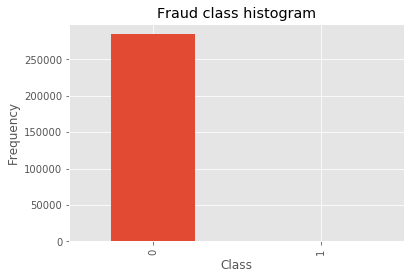

0    284315
1       492
Name: Class, dtype: int64

In [70]:
# Plot histogram for all data
count_classes = pd.value_counts(dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [71]:
# Split dataset on train_and_validation dataset and test dataset
train_and_validation, test = train_test_split(dataset, test_size = 0.3, random_state = 0)

# Convert test data to numpyarray and split them.
test = test.values
x_test = test[:,:-1]
y_test = test[:,-1:]

In [72]:
# Create balanced, under sample train and validation dataset 
fraud_indices = np.array(train_and_validation[train_and_validation.Class == 1].index)
normal_indices = np.array(train_and_validation[train_and_validation.Class == 0].index)

random_normal_indices = np.random.choice(normal_indices, NUMBER_OF_OK_TRANSACTIONS_IN_TRAIN_VALIDATION_DATASET, replace = False)
random_normal_indices = np.array(random_normal_indices)

under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])

under_sample_dataset = dataset.iloc[under_sample_indices,:]

# Shuffle train and validation dataset
under_sample_dataset = under_sample_dataset.sample(frac=1)

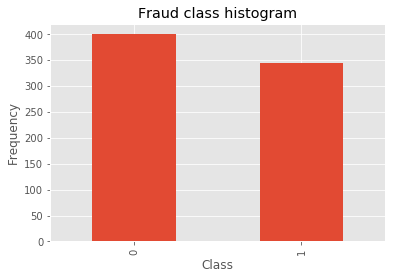

0    400
1    345
Name: Class, dtype: int64

In [73]:
# Plot histogram for training and validation dataset
count_classes = pd.value_counts(under_sample_dataset['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()
count_classes

In [74]:
# Convert training and validation dataset to numpy array
under_sample_dataset = under_sample_dataset.values

In [75]:
# Pot loss
def show_loss(history):   
    x_axis = range(0, EPOCHS)
    fig, ax = plt.subplots()
    ax.plot(x_axis, history.history['loss'], label='train_loss')
    ax.plot(x_axis, history.history['val_loss'], label='val_loss')
    ax.legend()
    plt.ylabel('Log loss')
    plt.xlabel('epoch number')
    plt.title('loss vs epoch number')
    
    plt.show()

In [76]:
# NN model
import keras.backend as K

def precision(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FP = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return TP / (TP_plus_FP + K.epsilon())

def recall(y_true, y_pred):
    TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    TP_plus_FN = K.sum(K.round(K.clip(y_true, 0, 1)))
    return TP / (TP_plus_FN + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * prec * rec / (prec + rec + K.epsilon())

def nn_model():
    model = models.Sequential()
    model.add(layers.Dense(NUMBER_OF_NEURONS,
                    input_dim=NUMBER_OF_FEATURES,
                    activation='relu',
                    kernel_regularizer=regularizers.l2(REGULARIZATION_LAMBDA)))
#     model.add(layers.Dense(NUMBER_OF_NEURONS, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    optimazier = optimizers.SGD(lr=LEARNING_RATE)
    model.compile(optimizer=optimazier,
                  loss='binary_crossentropy',
                  metrics=['accuracy', precision, recall, f1_score])
    return model

train_results = {'models': [], 'history': [], 'score': []}

kf = KFold(n_splits=N_SPLITS)
for train_index, validation_index in kf.split(under_sample_dataset):
    k_fold_train, k_fold_validation = under_sample_dataset[train_index], under_sample_dataset[validation_index]

    x_train = k_fold_train[:,:-1]
    y_train = k_fold_train[:,-1:]
        
    x_validation = k_fold_validation[:,:-1]
    y_validation = k_fold_validation[:,-1:]
    
    model = nn_model()
    history = model.fit(x_train, y_train, validation_data=(x_validation, y_validation), verbose=1, epochs=EPOCHS, batch_size=BATCH_SIZE)
    score = model.evaluate(x_validation, y_validation, batch_size=BATCH_SIZE)
    
    train_results['models'].append(model)
    train_results['history'].append(history)
    train_results['score'].append(score)

Train on 596 samples, validate on 149 samples
Epoch 1/1000
596/596 [==============================] - 0s - loss: 6.2246 - acc: 0.5604 - precision: 0.4805 - recall: 0.8037 - f1_score: 0.5869 - val_loss: 6.1162 - val_acc: 0.6309 - val_precision: 0.5698 - val_recall: 1.0000 - val_f1_score: 0.7256
Epoch 2/1000
596/596 [==============================] - 0s - loss: 6.0889 - acc: 0.5772 - precision: 0.5209 - recall: 0.9797 - f1_score: 0.6759 - val_loss: 6.0524 - val_acc: 0.5973 - val_precision: 0.5483 - val_recall: 1.0000 - val_f1_score: 0.7078
Epoch 3/1000
596/596 [==============================] - 0s - loss: 6.0389 - acc: 0.5923 - precision: 0.5297 - recall: 0.9818 - f1_score: 0.6866 - val_loss: 6.0070 - val_acc: 0.6309 - val_precision: 0.5713 - val_recall: 1.0000 - val_f1_score: 0.7260
Epoch 4/1000
596/596 [==============================] - 0s - loss: 5.9991 - acc: 0.6074 - precision: 0.5393 - recall: 0.9788 - f1_score: 0.6924 - val_loss: 5.9677 - val_acc: 0.6644 - val_precision: 0.5943 - 

596/596 [==============================] - 0s - loss: 5.1658 - acc: 0.9396 - precision: 0.9718 - recall: 0.8918 - f1_score: 0.9291 - val_loss: 5.1312 - val_acc: 0.9463 - val_precision: 0.9860 - val_recall: 0.9045 - val_f1_score: 0.9435
Epoch 34/1000
596/596 [==============================] - 0s - loss: 5.1406 - acc: 0.9396 - precision: 0.9725 - recall: 0.8918 - f1_score: 0.9287 - val_loss: 5.1061 - val_acc: 0.9463 - val_precision: 0.9860 - val_recall: 0.9045 - val_f1_score: 0.9435
Epoch 35/1000
596/596 [==============================] - 0s - loss: 5.1157 - acc: 0.9396 - precision: 0.9725 - recall: 0.9058 - f1_score: 0.9351 - val_loss: 5.0811 - val_acc: 0.9463 - val_precision: 0.9860 - val_recall: 0.9045 - val_f1_score: 0.9435
Epoch 36/1000
596/596 [==============================] - 0s - loss: 5.0908 - acc: 0.9379 - precision: 0.9706 - recall: 0.8951 - f1_score: 0.9300 - val_loss: 5.0564 - val_acc: 0.9463 - val_precision: 0.9860 - val_recall: 0.9045 - val_f1_score: 0.9435
Epoch 37/1000


596/596 [==============================] - 0s - loss: 4.4337 - acc: 0.9379 - precision: 0.9771 - recall: 0.8797 - f1_score: 0.9247 - val_loss: 4.4021 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 66/1000
596/596 [==============================] - 0s - loss: 4.4130 - acc: 0.9379 - precision: 0.9792 - recall: 0.8800 - f1_score: 0.9262 - val_loss: 4.3815 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 67/1000
596/596 [==============================] - 0s - loss: 4.3924 - acc: 0.9379 - precision: 0.9830 - recall: 0.8804 - f1_score: 0.9268 - val_loss: 4.3610 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 68/1000
596/596 [==============================] - 0s - loss: 4.3719 - acc: 0.9379 - precision: 0.9789 - recall: 0.8814 - f1_score: 0.9265 - val_loss: 4.3406 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 69/1000


596/596 [==============================] - 0s - loss: 3.8233 - acc: 0.9362 - precision: 0.9802 - recall: 0.8802 - f1_score: 0.9251 - val_loss: 3.7951 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 98/1000
596/596 [==============================] - 0s - loss: 3.8059 - acc: 0.9362 - precision: 0.9793 - recall: 0.8779 - f1_score: 0.9238 - val_loss: 3.7777 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 99/1000
596/596 [==============================] - 0s - loss: 3.7885 - acc: 0.9362 - precision: 0.9781 - recall: 0.8798 - f1_score: 0.9243 - val_loss: 3.7605 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 100/1000
596/596 [==============================] - 0s - loss: 3.7712 - acc: 0.9362 - precision: 0.9800 - recall: 0.8763 - f1_score: 0.9242 - val_loss: 3.7433 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 101/100

596/596 [==============================] - 0s - loss: 3.3068 - acc: 0.9379 - precision: 0.9814 - recall: 0.8838 - f1_score: 0.9295 - val_loss: 3.2817 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 130/1000
596/596 [==============================] - 0s - loss: 3.2920 - acc: 0.9379 - precision: 0.9786 - recall: 0.8844 - f1_score: 0.9278 - val_loss: 3.2670 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 131/1000
596/596 [==============================] - 0s - loss: 3.2772 - acc: 0.9379 - precision: 0.9778 - recall: 0.8761 - f1_score: 0.9223 - val_loss: 3.2523 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 132/1000
596/596 [==============================] - 0s - loss: 3.2625 - acc: 0.9379 - precision: 0.9816 - recall: 0.8809 - f1_score: 0.9276 - val_loss: 3.2377 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 133/1

596/596 [==============================] - 0s - loss: 2.8670 - acc: 0.9379 - precision: 0.9796 - recall: 0.8830 - f1_score: 0.9278 - val_loss: 2.8447 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 162/1000
596/596 [==============================] - 0s - loss: 2.8543 - acc: 0.9379 - precision: 0.9800 - recall: 0.8805 - f1_score: 0.9257 - val_loss: 2.8321 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 163/1000
596/596 [==============================] - 0s - loss: 2.8417 - acc: 0.9379 - precision: 0.9819 - recall: 0.8812 - f1_score: 0.9275 - val_loss: 2.8196 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 164/1000
596/596 [==============================] - 0s - loss: 2.8292 - acc: 0.9379 - precision: 0.9807 - recall: 0.8853 - f1_score: 0.9295 - val_loss: 2.8072 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 165/1

596/596 [==============================] - 0s - loss: 2.4913 - acc: 0.9379 - precision: 0.9782 - recall: 0.8860 - f1_score: 0.9289 - val_loss: 2.4715 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 194/1000
596/596 [==============================] - 0s - loss: 2.4805 - acc: 0.9379 - precision: 0.9812 - recall: 0.8821 - f1_score: 0.9282 - val_loss: 2.4607 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 195/1000
596/596 [==============================] - 0s - loss: 2.4697 - acc: 0.9379 - precision: 0.9792 - recall: 0.8809 - f1_score: 0.9262 - val_loss: 2.4500 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 196/1000
596/596 [==============================] - 0s - loss: 2.4590 - acc: 0.9379 - precision: 0.9799 - recall: 0.8805 - f1_score: 0.9262 - val_loss: 2.4394 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 197/1

596/596 [==============================] - 0s - loss: 2.1698 - acc: 0.9379 - precision: 0.9792 - recall: 0.8816 - f1_score: 0.9268 - val_loss: 2.1521 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 226/1000
596/596 [==============================] - 0s - loss: 2.1605 - acc: 0.9379 - precision: 0.9816 - recall: 0.8825 - f1_score: 0.9286 - val_loss: 2.1429 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 227/1000
596/596 [==============================] - 0s - loss: 2.1513 - acc: 0.9379 - precision: 0.9817 - recall: 0.8822 - f1_score: 0.9281 - val_loss: 2.1338 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 228/1000
596/596 [==============================] - 0s - loss: 2.1421 - acc: 0.9379 - precision: 0.9799 - recall: 0.8903 - f1_score: 0.9300 - val_loss: 2.1246 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 229/1

596/596 [==============================] - 0s - loss: 1.8944 - acc: 0.9379 - precision: 0.9807 - recall: 0.8836 - f1_score: 0.9281 - val_loss: 1.8786 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 258/1000
596/596 [==============================] - 0s - loss: 1.8864 - acc: 0.9379 - precision: 0.9792 - recall: 0.8865 - f1_score: 0.9299 - val_loss: 1.8707 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 259/1000
596/596 [==============================] - 0s - loss: 1.8785 - acc: 0.9379 - precision: 0.9802 - recall: 0.8784 - f1_score: 0.9241 - val_loss: 1.8628 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 260/1000
596/596 [==============================] - 0s - loss: 1.8707 - acc: 0.9379 - precision: 0.9777 - recall: 0.8867 - f1_score: 0.9285 - val_loss: 1.8550 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 261/1

596/596 [==============================] - 0s - loss: 1.6582 - acc: 0.9396 - precision: 0.9816 - recall: 0.8905 - f1_score: 0.9325 - val_loss: 1.6440 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 290/1000
596/596 [==============================] - 0s - loss: 1.6514 - acc: 0.9396 - precision: 0.9820 - recall: 0.8830 - f1_score: 0.9288 - val_loss: 1.6373 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 291/1000
596/596 [==============================] - 0s - loss: 1.6446 - acc: 0.9396 - precision: 0.9778 - recall: 0.8819 - f1_score: 0.9260 - val_loss: 1.6305 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 292/1000
596/596 [==============================] - 0s - loss: 1.6379 - acc: 0.9396 - precision: 0.9803 - recall: 0.8858 - f1_score: 0.9296 - val_loss: 1.6238 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 293/1

596/596 [==============================] - 0s - loss: 1.4555 - acc: 0.9396 - precision: 0.9797 - recall: 0.8865 - f1_score: 0.9298 - val_loss: 1.4428 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 322/1000
596/596 [==============================] - 0s - loss: 1.4497 - acc: 0.9396 - precision: 0.9748 - recall: 0.8826 - f1_score: 0.9251 - val_loss: 1.4370 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 323/1000
596/596 [==============================] - 0s - loss: 1.4439 - acc: 0.9396 - precision: 0.9804 - recall: 0.8862 - f1_score: 0.9305 - val_loss: 1.4312 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 324/1000
596/596 [==============================] - 0s - loss: 1.4381 - acc: 0.9396 - precision: 0.9773 - recall: 0.8882 - f1_score: 0.9294 - val_loss: 1.4255 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 325/1

596/596 [==============================] - 0s - loss: 1.2815 - acc: 0.9396 - precision: 0.9797 - recall: 0.8839 - f1_score: 0.9277 - val_loss: 1.2701 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 354/1000
596/596 [==============================] - 0s - loss: 1.2765 - acc: 0.9396 - precision: 0.9799 - recall: 0.8850 - f1_score: 0.9289 - val_loss: 1.2651 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 355/1000
596/596 [==============================] - 0s - loss: 1.2715 - acc: 0.9396 - precision: 0.9814 - recall: 0.8874 - f1_score: 0.9314 - val_loss: 1.2601 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 356/1000
596/596 [==============================] - 0s - loss: 1.2665 - acc: 0.9396 - precision: 0.9794 - recall: 0.8870 - f1_score: 0.9301 - val_loss: 1.2552 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 357/1

596/596 [==============================] - 0s - loss: 1.1321 - acc: 0.9413 - precision: 0.9796 - recall: 0.8886 - f1_score: 0.9310 - val_loss: 1.1217 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 386/1000
596/596 [==============================] - 0s - loss: 1.1277 - acc: 0.9413 - precision: 0.9793 - recall: 0.8917 - f1_score: 0.9323 - val_loss: 1.1174 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 387/1000
596/596 [==============================] - 0s - loss: 1.1234 - acc: 0.9413 - precision: 0.9808 - recall: 0.8906 - f1_score: 0.9330 - val_loss: 1.1131 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 388/1000
596/596 [==============================] - 0s - loss: 1.1192 - acc: 0.9413 - precision: 0.9793 - recall: 0.8867 - f1_score: 0.9291 - val_loss: 1.1089 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 389/1

596/596 [==============================] - 0s - loss: 1.0036 - acc: 0.9430 - precision: 0.9790 - recall: 0.8907 - f1_score: 0.9318 - val_loss: 0.9942 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 418/1000
596/596 [==============================] - 0s - loss: 0.9998 - acc: 0.9430 - precision: 0.9807 - recall: 0.8928 - f1_score: 0.9338 - val_loss: 0.9905 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 419/1000
596/596 [==============================] - 0s - loss: 0.9962 - acc: 0.9430 - precision: 0.9790 - recall: 0.8968 - f1_score: 0.9349 - val_loss: 0.9868 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 420/1000
596/596 [==============================] - 0s - loss: 0.9925 - acc: 0.9430 - precision: 0.9755 - recall: 0.8893 - f1_score: 0.9291 - val_loss: 0.9832 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 421/1

596/596 [==============================] - 0s - loss: 0.8930 - acc: 0.9430 - precision: 0.9794 - recall: 0.8939 - f1_score: 0.9330 - val_loss: 0.8845 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 450/1000
596/596 [==============================] - 0s - loss: 0.8898 - acc: 0.9430 - precision: 0.9798 - recall: 0.8954 - f1_score: 0.9342 - val_loss: 0.8813 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 451/1000
596/596 [==============================] - 0s - loss: 0.8866 - acc: 0.9430 - precision: 0.9803 - recall: 0.8912 - f1_score: 0.9314 - val_loss: 0.8782 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 452/1000
596/596 [==============================] - 0s - loss: 0.8835 - acc: 0.9430 - precision: 0.9804 - recall: 0.8920 - f1_score: 0.9324 - val_loss: 0.8750 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 453/1

596/596 [==============================] - 0s - loss: 0.7979 - acc: 0.9430 - precision: 0.9795 - recall: 0.8959 - f1_score: 0.9344 - val_loss: 0.7901 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 482/1000
596/596 [==============================] - 0s - loss: 0.7951 - acc: 0.9430 - precision: 0.9802 - recall: 0.8926 - f1_score: 0.9335 - val_loss: 0.7874 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 483/1000
596/596 [==============================] - 0s - loss: 0.7924 - acc: 0.9430 - precision: 0.9810 - recall: 0.8980 - f1_score: 0.9359 - val_loss: 0.7847 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 484/1000
596/596 [==============================] - 0s - loss: 0.7897 - acc: 0.9430 - precision: 0.9781 - recall: 0.8873 - f1_score: 0.9292 - val_loss: 0.7819 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 485/1

596/596 [==============================] - 0s - loss: 0.7159 - acc: 0.9430 - precision: 0.9801 - recall: 0.8920 - f1_score: 0.9325 - val_loss: 0.7088 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 514/1000
596/596 [==============================] - 0s - loss: 0.7136 - acc: 0.9430 - precision: 0.9806 - recall: 0.8946 - f1_score: 0.9345 - val_loss: 0.7065 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 515/1000
596/596 [==============================] - 0s - loss: 0.7112 - acc: 0.9430 - precision: 0.9814 - recall: 0.8912 - f1_score: 0.9309 - val_loss: 0.7041 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 516/1000
596/596 [==============================] - 0s - loss: 0.7089 - acc: 0.9430 - precision: 0.9818 - recall: 0.8891 - f1_score: 0.9311 - val_loss: 0.7018 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 517/1

596/596 [==============================] - 0s - loss: 0.6453 - acc: 0.9430 - precision: 0.9806 - recall: 0.8916 - f1_score: 0.9323 - val_loss: 0.6387 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 546/1000
596/596 [==============================] - 0s - loss: 0.6433 - acc: 0.9430 - precision: 0.9787 - recall: 0.8958 - f1_score: 0.9339 - val_loss: 0.6367 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 547/1000
596/596 [==============================] - 0s - loss: 0.6412 - acc: 0.9430 - precision: 0.9788 - recall: 0.8894 - f1_score: 0.9310 - val_loss: 0.6347 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 548/1000
596/596 [==============================] - 0s - loss: 0.6392 - acc: 0.9430 - precision: 0.9796 - recall: 0.8936 - f1_score: 0.9332 - val_loss: 0.6327 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 549/1

596/596 [==============================] - 0s - loss: 0.5844 - acc: 0.9430 - precision: 0.9802 - recall: 0.8922 - f1_score: 0.9332 - val_loss: 0.5782 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 578/1000
596/596 [==============================] - 0s - loss: 0.5826 - acc: 0.9430 - precision: 0.9812 - recall: 0.8941 - f1_score: 0.9347 - val_loss: 0.5765 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 579/1000
596/596 [==============================] - 0s - loss: 0.5809 - acc: 0.9430 - precision: 0.9802 - recall: 0.8979 - f1_score: 0.9351 - val_loss: 0.5747 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 580/1000
596/596 [==============================] - 0s - loss: 0.5791 - acc: 0.9430 - precision: 0.9803 - recall: 0.8961 - f1_score: 0.9354 - val_loss: 0.5730 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 581/1

596/596 [==============================] - 0s - loss: 0.5317 - acc: 0.9430 - precision: 0.9792 - recall: 0.8960 - f1_score: 0.9346 - val_loss: 0.5260 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 610/1000
596/596 [==============================] - 0s - loss: 0.5302 - acc: 0.9430 - precision: 0.9796 - recall: 0.8923 - f1_score: 0.9326 - val_loss: 0.5245 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 611/1000
596/596 [==============================] - 0s - loss: 0.5287 - acc: 0.9430 - precision: 0.9810 - recall: 0.9004 - f1_score: 0.9372 - val_loss: 0.5230 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 612/1000
596/596 [==============================] - 0s - loss: 0.5272 - acc: 0.9430 - precision: 0.9794 - recall: 0.8942 - f1_score: 0.9329 - val_loss: 0.5215 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 613/1

596/596 [==============================] - 0s - loss: 0.4863 - acc: 0.9430 - precision: 0.9806 - recall: 0.8987 - f1_score: 0.9360 - val_loss: 0.4809 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 642/1000
596/596 [==============================] - 0s - loss: 0.4849 - acc: 0.9430 - precision: 0.9784 - recall: 0.8933 - f1_score: 0.9332 - val_loss: 0.4795 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 643/1000
596/596 [==============================] - 0s - loss: 0.4836 - acc: 0.9430 - precision: 0.9831 - recall: 0.8974 - f1_score: 0.9373 - val_loss: 0.4782 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 644/1000
596/596 [==============================] - 0s - loss: 0.4823 - acc: 0.9430 - precision: 0.9810 - recall: 0.8957 - f1_score: 0.9346 - val_loss: 0.4769 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 645/1

596/596 [==============================] - 0s - loss: 0.4469 - acc: 0.9430 - precision: 0.9812 - recall: 0.8907 - f1_score: 0.9317 - val_loss: 0.4418 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 674/1000
596/596 [==============================] - 0s - loss: 0.4457 - acc: 0.9430 - precision: 0.9822 - recall: 0.8971 - f1_score: 0.9369 - val_loss: 0.4406 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 675/1000
596/596 [==============================] - 0s - loss: 0.4446 - acc: 0.9430 - precision: 0.9812 - recall: 0.8936 - f1_score: 0.9337 - val_loss: 0.4395 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 676/1000
596/596 [==============================] - 0s - loss: 0.4435 - acc: 0.9430 - precision: 0.9789 - recall: 0.8936 - f1_score: 0.9332 - val_loss: 0.4384 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 677/1

596/596 [==============================] - 0s - loss: 0.4128 - acc: 0.9430 - precision: 0.9819 - recall: 0.8964 - f1_score: 0.9358 - val_loss: 0.4079 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 706/1000
596/596 [==============================] - 0s - loss: 0.4118 - acc: 0.9430 - precision: 0.9816 - recall: 0.8917 - f1_score: 0.9336 - val_loss: 0.4069 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 707/1000
596/596 [==============================] - 0s - loss: 0.4108 - acc: 0.9430 - precision: 0.9800 - recall: 0.8930 - f1_score: 0.9334 - val_loss: 0.4059 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 708/1000
596/596 [==============================] - 0s - loss: 0.4098 - acc: 0.9430 - precision: 0.9762 - recall: 0.8948 - f1_score: 0.9327 - val_loss: 0.4049 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 709/1

596/596 [==============================] - 0s - loss: 0.3832 - acc: 0.9430 - precision: 0.9819 - recall: 0.8928 - f1_score: 0.9338 - val_loss: 0.3784 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 738/1000
596/596 [==============================] - 0s - loss: 0.3823 - acc: 0.9430 - precision: 0.9787 - recall: 0.8947 - f1_score: 0.9338 - val_loss: 0.3776 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 739/1000
596/596 [==============================] - 0s - loss: 0.3815 - acc: 0.9430 - precision: 0.9795 - recall: 0.8892 - f1_score: 0.9305 - val_loss: 0.3767 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 740/1000
596/596 [==============================] - 0s - loss: 0.3806 - acc: 0.9430 - precision: 0.9775 - recall: 0.8922 - f1_score: 0.9317 - val_loss: 0.3759 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 741/1

596/596 [==============================] - 0s - loss: 0.3575 - acc: 0.9430 - precision: 0.9790 - recall: 0.9030 - f1_score: 0.9377 - val_loss: 0.3528 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 770/1000
596/596 [==============================] - 0s - loss: 0.3568 - acc: 0.9430 - precision: 0.9818 - recall: 0.8926 - f1_score: 0.9336 - val_loss: 0.3521 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 771/1000
596/596 [==============================] - 0s - loss: 0.3560 - acc: 0.9430 - precision: 0.9811 - recall: 0.8957 - f1_score: 0.9356 - val_loss: 0.3514 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 772/1000
596/596 [==============================] - 0s - loss: 0.3553 - acc: 0.9430 - precision: 0.9807 - recall: 0.8913 - f1_score: 0.9325 - val_loss: 0.3506 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 773/1

596/596 [==============================] - 0s - loss: 0.3352 - acc: 0.9430 - precision: 0.9768 - recall: 0.8888 - f1_score: 0.9294 - val_loss: 0.3306 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 802/1000
596/596 [==============================] - 0s - loss: 0.3345 - acc: 0.9430 - precision: 0.9815 - recall: 0.8974 - f1_score: 0.9356 - val_loss: 0.3299 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 803/1000
596/596 [==============================] - 0s - loss: 0.3339 - acc: 0.9430 - precision: 0.9787 - recall: 0.8984 - f1_score: 0.9356 - val_loss: 0.3293 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 804/1000
596/596 [==============================] - 0s - loss: 0.3332 - acc: 0.9430 - precision: 0.9810 - recall: 0.8930 - f1_score: 0.9337 - val_loss: 0.3286 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 805/1

596/596 [==============================] - 0s - loss: 0.3157 - acc: 0.9430 - precision: 0.9790 - recall: 0.8967 - f1_score: 0.9350 - val_loss: 0.3111 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 834/1000
596/596 [==============================] - 0s - loss: 0.3151 - acc: 0.9430 - precision: 0.9799 - recall: 0.8935 - f1_score: 0.9332 - val_loss: 0.3106 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 835/1000
596/596 [==============================] - 0s - loss: 0.3146 - acc: 0.9430 - precision: 0.9828 - recall: 0.8952 - f1_score: 0.9363 - val_loss: 0.3100 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 836/1000
596/596 [==============================] - 0s - loss: 0.3140 - acc: 0.9430 - precision: 0.9804 - recall: 0.8903 - f1_score: 0.9319 - val_loss: 0.3094 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 837/1

596/596 [==============================] - 0s - loss: 0.2987 - acc: 0.9430 - precision: 0.9810 - recall: 0.8943 - f1_score: 0.9338 - val_loss: 0.2941 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 866/1000
596/596 [==============================] - 0s - loss: 0.2982 - acc: 0.9430 - precision: 0.9803 - recall: 0.8931 - f1_score: 0.9332 - val_loss: 0.2936 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 867/1000
596/596 [==============================] - 0s - loss: 0.2978 - acc: 0.9430 - precision: 0.9790 - recall: 0.8934 - f1_score: 0.9333 - val_loss: 0.2932 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 868/1000
596/596 [==============================] - 0s - loss: 0.2973 - acc: 0.9430 - precision: 0.9812 - recall: 0.8895 - f1_score: 0.9317 - val_loss: 0.2927 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 869/1

596/596 [==============================] - 0s - loss: 0.2839 - acc: 0.9430 - precision: 0.9793 - recall: 0.8906 - f1_score: 0.9316 - val_loss: 0.2793 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 898/1000
596/596 [==============================] - 0s - loss: 0.2835 - acc: 0.9430 - precision: 0.9792 - recall: 0.8928 - f1_score: 0.9330 - val_loss: 0.2788 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 899/1000
596/596 [==============================] - 0s - loss: 0.2831 - acc: 0.9430 - precision: 0.9814 - recall: 0.8944 - f1_score: 0.9344 - val_loss: 0.2784 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 900/1000
596/596 [==============================] - 0s - loss: 0.2827 - acc: 0.9430 - precision: 0.9796 - recall: 0.8928 - f1_score: 0.9332 - val_loss: 0.2780 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 901/1

596/596 [==============================] - 0s - loss: 0.2710 - acc: 0.9430 - precision: 0.9794 - recall: 0.8936 - f1_score: 0.9331 - val_loss: 0.2663 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 930/1000
596/596 [==============================] - 0s - loss: 0.2706 - acc: 0.9430 - precision: 0.9767 - recall: 0.8863 - f1_score: 0.9286 - val_loss: 0.2659 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 931/1000
596/596 [==============================] - 0s - loss: 0.2703 - acc: 0.9430 - precision: 0.9817 - recall: 0.8934 - f1_score: 0.9338 - val_loss: 0.2655 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 932/1000
596/596 [==============================] - 0s - loss: 0.2699 - acc: 0.9430 - precision: 0.9814 - recall: 0.8859 - f1_score: 0.9281 - val_loss: 0.2651 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 933/1

596/596 [==============================] - 0s - loss: 0.2597 - acc: 0.9430 - precision: 0.9802 - recall: 0.8935 - f1_score: 0.9326 - val_loss: 0.2549 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 962/1000
596/596 [==============================] - 0s - loss: 0.2594 - acc: 0.9430 - precision: 0.9814 - recall: 0.9004 - f1_score: 0.9386 - val_loss: 0.2546 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 963/1000
596/596 [==============================] - 0s - loss: 0.2591 - acc: 0.9430 - precision: 0.9810 - recall: 0.8901 - f1_score: 0.9325 - val_loss: 0.2542 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 964/1000
596/596 [==============================] - 0s - loss: 0.2587 - acc: 0.9430 - precision: 0.9810 - recall: 0.8944 - f1_score: 0.9346 - val_loss: 0.2539 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 965/1

596/596 [==============================] - 0s - loss: 0.2498 - acc: 0.9430 - precision: 0.9800 - recall: 0.8966 - f1_score: 0.9349 - val_loss: 0.2449 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 994/1000
596/596 [==============================] - 0s - loss: 0.2495 - acc: 0.9430 - precision: 0.9810 - recall: 0.8916 - f1_score: 0.9323 - val_loss: 0.2446 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 995/1000
596/596 [==============================] - 0s - loss: 0.2492 - acc: 0.9430 - precision: 0.9793 - recall: 0.8891 - f1_score: 0.9308 - val_loss: 0.2443 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 996/1000
596/596 [==============================] - 0s - loss: 0.2490 - acc: 0.9430 - precision: 0.9808 - recall: 0.8936 - f1_score: 0.9344 - val_loss: 0.2440 - val_acc: 0.9463 - val_precision: 1.0000 - val_recall: 0.8892 - val_f1_score: 0.9412
Epoch 997/1

596/596 [==============================] - 0s - loss: 5.3800 - acc: 0.9379 - precision: 0.9550 - recall: 0.9110 - f1_score: 0.9307 - val_loss: 5.3592 - val_acc: 0.9530 - val_precision: 0.9851 - val_recall: 0.9176 - val_f1_score: 0.9501
Epoch 26/1000
596/596 [==============================] - 0s - loss: 5.3532 - acc: 0.9396 - precision: 0.9576 - recall: 0.9104 - f1_score: 0.9324 - val_loss: 5.3326 - val_acc: 0.9530 - val_precision: 0.9851 - val_recall: 0.9176 - val_f1_score: 0.9501
Epoch 27/1000
596/596 [==============================] - 0s - loss: 5.3266 - acc: 0.9396 - precision: 0.9571 - recall: 0.9144 - f1_score: 0.9337 - val_loss: 5.3063 - val_acc: 0.9530 - val_precision: 0.9851 - val_recall: 0.9176 - val_f1_score: 0.9501
Epoch 28/1000
596/596 [==============================] - 0s - loss: 5.3001 - acc: 0.9396 - precision: 0.9616 - recall: 0.9020 - f1_score: 0.9292 - val_loss: 5.2801 - val_acc: 0.9530 - val_precision: 0.9851 - val_recall: 0.9176 - val_f1_score: 0.9501
Epoch 29/1000


596/596 [==============================] - 0s - loss: 4.6070 - acc: 0.9379 - precision: 0.9841 - recall: 0.8831 - f1_score: 0.9288 - val_loss: 4.5923 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 58/1000
596/596 [==============================] - 0s - loss: 4.5853 - acc: 0.9379 - precision: 0.9831 - recall: 0.8826 - f1_score: 0.9277 - val_loss: 4.5707 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 59/1000
596/596 [==============================] - 0s - loss: 4.5636 - acc: 0.9379 - precision: 0.9840 - recall: 0.8766 - f1_score: 0.9255 - val_loss: 4.5492 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 60/1000
596/596 [==============================] - 0s - loss: 4.5422 - acc: 0.9396 - precision: 0.9876 - recall: 0.8778 - f1_score: 0.9277 - val_loss: 4.5279 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 61/1000


596/596 [==============================] - 0s - loss: 3.9685 - acc: 0.9379 - precision: 0.9865 - recall: 0.8713 - f1_score: 0.9240 - val_loss: 3.9575 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 90/1000
596/596 [==============================] - 0s - loss: 3.9503 - acc: 0.9379 - precision: 0.9845 - recall: 0.8740 - f1_score: 0.9244 - val_loss: 3.9394 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 91/1000
596/596 [==============================] - 0s - loss: 3.9322 - acc: 0.9379 - precision: 0.9868 - recall: 0.8746 - f1_score: 0.9263 - val_loss: 3.9214 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 92/1000
596/596 [==============================] - 0s - loss: 3.9142 - acc: 0.9362 - precision: 0.9880 - recall: 0.8726 - f1_score: 0.9257 - val_loss: 3.9034 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 93/1000


596/596 [==============================] - 0s - loss: 3.4299 - acc: 0.9379 - precision: 0.9871 - recall: 0.8701 - f1_score: 0.9235 - val_loss: 3.4216 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 122/1000
596/596 [==============================] - 0s - loss: 3.4144 - acc: 0.9379 - precision: 0.9890 - recall: 0.8734 - f1_score: 0.9269 - val_loss: 3.4062 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 123/1000
596/596 [==============================] - 0s - loss: 3.3991 - acc: 0.9379 - precision: 0.9890 - recall: 0.8774 - f1_score: 0.9271 - val_loss: 3.3909 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 124/1000
596/596 [==============================] - 0s - loss: 3.3838 - acc: 0.9379 - precision: 0.9895 - recall: 0.8717 - f1_score: 0.9251 - val_loss: 3.3757 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 125/1

596/596 [==============================] - 0s - loss: 2.9717 - acc: 0.9379 - precision: 0.9873 - recall: 0.8725 - f1_score: 0.9248 - val_loss: 2.9657 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 154/1000
596/596 [==============================] - 0s - loss: 2.9585 - acc: 0.9379 - precision: 0.9889 - recall: 0.8691 - f1_score: 0.9233 - val_loss: 2.9526 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 155/1000
596/596 [==============================] - 0s - loss: 2.9454 - acc: 0.9379 - precision: 0.9883 - recall: 0.8783 - f1_score: 0.9287 - val_loss: 2.9396 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 156/1000
596/596 [==============================] - 0s - loss: 2.9324 - acc: 0.9379 - precision: 0.9886 - recall: 0.8767 - f1_score: 0.9275 - val_loss: 2.9266 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 157/1

596/596 [==============================] - 0s - loss: 2.5806 - acc: 0.9396 - precision: 0.9902 - recall: 0.8764 - f1_score: 0.9271 - val_loss: 2.5767 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 186/1000
596/596 [==============================] - 0s - loss: 2.5693 - acc: 0.9396 - precision: 0.9890 - recall: 0.8775 - f1_score: 0.9293 - val_loss: 2.5655 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 187/1000
596/596 [==============================] - 0s - loss: 2.5581 - acc: 0.9396 - precision: 0.9859 - recall: 0.8820 - f1_score: 0.9294 - val_loss: 2.5543 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 188/1000
596/596 [==============================] - 0s - loss: 2.5469 - acc: 0.9396 - precision: 0.9866 - recall: 0.8779 - f1_score: 0.9286 - val_loss: 2.5432 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 189/1

596/596 [==============================] - 0s - loss: 2.2459 - acc: 0.9396 - precision: 0.9860 - recall: 0.8768 - f1_score: 0.9271 - val_loss: 2.2439 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 218/1000
596/596 [==============================] - 0s - loss: 2.2363 - acc: 0.9396 - precision: 0.9888 - recall: 0.8783 - f1_score: 0.9277 - val_loss: 2.2343 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 219/1000
596/596 [==============================] - 0s - loss: 2.2267 - acc: 0.9396 - precision: 0.9881 - recall: 0.8811 - f1_score: 0.9298 - val_loss: 2.2248 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 220/1000
596/596 [==============================] - 0s - loss: 2.2171 - acc: 0.9396 - precision: 0.9889 - recall: 0.8768 - f1_score: 0.9286 - val_loss: 2.2153 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 221/1

596/596 [==============================] - 0s - loss: 1.9593 - acc: 0.9413 - precision: 0.9878 - recall: 0.8810 - f1_score: 0.9300 - val_loss: 1.9590 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 250/1000
596/596 [==============================] - 0s - loss: 1.9510 - acc: 0.9413 - precision: 0.9860 - recall: 0.8835 - f1_score: 0.9309 - val_loss: 1.9507 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 251/1000
596/596 [==============================] - 0s - loss: 1.9428 - acc: 0.9413 - precision: 0.9887 - recall: 0.8801 - f1_score: 0.9301 - val_loss: 1.9426 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 252/1000
596/596 [==============================] - 0s - loss: 1.9346 - acc: 0.9413 - precision: 0.9835 - recall: 0.8780 - f1_score: 0.9269 - val_loss: 1.9344 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 253/1

596/596 [==============================] - 0s - loss: 1.7135 - acc: 0.9413 - precision: 0.9884 - recall: 0.8799 - f1_score: 0.9270 - val_loss: 1.7148 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 282/1000
596/596 [==============================] - 0s - loss: 1.7064 - acc: 0.9413 - precision: 0.9880 - recall: 0.8742 - f1_score: 0.9255 - val_loss: 1.7077 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 283/1000
596/596 [==============================] - 0s - loss: 1.6993 - acc: 0.9413 - precision: 0.9867 - recall: 0.8800 - f1_score: 0.9285 - val_loss: 1.7007 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 284/1000
596/596 [==============================] - 0s - loss: 1.6923 - acc: 0.9413 - precision: 0.9876 - recall: 0.8851 - f1_score: 0.9322 - val_loss: 1.6937 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 285/1

596/596 [==============================] - 0s - loss: 1.5026 - acc: 0.9413 - precision: 0.9884 - recall: 0.8874 - f1_score: 0.9321 - val_loss: 1.5054 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 314/1000
596/596 [==============================] - 0s - loss: 1.4965 - acc: 0.9413 - precision: 0.9876 - recall: 0.8837 - f1_score: 0.9312 - val_loss: 1.4993 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 315/1000
596/596 [==============================] - 0s - loss: 1.4905 - acc: 0.9413 - precision: 0.9881 - recall: 0.8833 - f1_score: 0.9312 - val_loss: 1.4933 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 316/1000
596/596 [==============================] - 0s - loss: 1.4844 - acc: 0.9413 - precision: 0.9871 - recall: 0.8817 - f1_score: 0.9306 - val_loss: 1.4873 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 317/1

596/596 [==============================] - 0s - loss: 1.3216 - acc: 0.9396 - precision: 0.9855 - recall: 0.8837 - f1_score: 0.9307 - val_loss: 1.3256 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 346/1000
596/596 [==============================] - 0s - loss: 1.3163 - acc: 0.9396 - precision: 0.9830 - recall: 0.8803 - f1_score: 0.9279 - val_loss: 1.3205 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 347/1000
596/596 [==============================] - 0s - loss: 1.3111 - acc: 0.9396 - precision: 0.9835 - recall: 0.8812 - f1_score: 0.9289 - val_loss: 1.3153 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 348/1000
596/596 [==============================] - 0s - loss: 1.3060 - acc: 0.9396 - precision: 0.9847 - recall: 0.8849 - f1_score: 0.9299 - val_loss: 1.3102 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 349/1

596/596 [==============================] - 0s - loss: 1.1660 - acc: 0.9396 - precision: 0.9830 - recall: 0.8808 - f1_score: 0.9266 - val_loss: 1.1713 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 378/1000
596/596 [==============================] - 0s - loss: 1.1615 - acc: 0.9396 - precision: 0.9839 - recall: 0.8812 - f1_score: 0.9284 - val_loss: 1.1669 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 379/1000
596/596 [==============================] - 0s - loss: 1.1571 - acc: 0.9396 - precision: 0.9842 - recall: 0.8839 - f1_score: 0.9290 - val_loss: 1.1624 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 380/1000
596/596 [==============================] - 0s - loss: 1.1526 - acc: 0.9396 - precision: 0.9830 - recall: 0.8884 - f1_score: 0.9314 - val_loss: 1.1580 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 381/1

596/596 [==============================] - 0s - loss: 1.0323 - acc: 0.9413 - precision: 0.9833 - recall: 0.8908 - f1_score: 0.9337 - val_loss: 1.0387 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 410/1000
596/596 [==============================] - 0s - loss: 1.0285 - acc: 0.9413 - precision: 0.9842 - recall: 0.8858 - f1_score: 0.9303 - val_loss: 1.0349 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 411/1000
596/596 [==============================] - 0s - loss: 1.0246 - acc: 0.9413 - precision: 0.9816 - recall: 0.8879 - f1_score: 0.9312 - val_loss: 1.0311 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 412/1000
596/596 [==============================] - 0s - loss: 1.0208 - acc: 0.9413 - precision: 0.9848 - recall: 0.8884 - f1_score: 0.9321 - val_loss: 1.0273 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 413/1

596/596 [==============================] - 0s - loss: 0.9173 - acc: 0.9413 - precision: 0.9823 - recall: 0.8807 - f1_score: 0.9272 - val_loss: 0.9248 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 442/1000
596/596 [==============================] - 0s - loss: 0.9140 - acc: 0.9413 - precision: 0.9836 - recall: 0.8812 - f1_score: 0.9285 - val_loss: 0.9215 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 443/1000
596/596 [==============================] - 0s - loss: 0.9107 - acc: 0.9413 - precision: 0.9858 - recall: 0.8818 - f1_score: 0.9295 - val_loss: 0.9182 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 444/1000
596/596 [==============================] - 0s - loss: 0.9074 - acc: 0.9413 - precision: 0.9846 - recall: 0.8870 - f1_score: 0.9317 - val_loss: 0.9149 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 445/1

596/596 [==============================] - 0s - loss: 0.8183 - acc: 0.9413 - precision: 0.9827 - recall: 0.8840 - f1_score: 0.9301 - val_loss: 0.8267 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 474/1000
596/596 [==============================] - 0s - loss: 0.8155 - acc: 0.9413 - precision: 0.9845 - recall: 0.8874 - f1_score: 0.9324 - val_loss: 0.8239 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 475/1000
596/596 [==============================] - 0s - loss: 0.8126 - acc: 0.9413 - precision: 0.9809 - recall: 0.8809 - f1_score: 0.9266 - val_loss: 0.8211 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 476/1000
596/596 [==============================] - 0s - loss: 0.8098 - acc: 0.9413 - precision: 0.9812 - recall: 0.8845 - f1_score: 0.9291 - val_loss: 0.8183 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 477/1

596/596 [==============================] - 0s - loss: 0.7331 - acc: 0.9430 - precision: 0.9823 - recall: 0.8952 - f1_score: 0.9358 - val_loss: 0.7423 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 506/1000
596/596 [==============================] - 0s - loss: 0.7306 - acc: 0.9430 - precision: 0.9835 - recall: 0.8882 - f1_score: 0.9327 - val_loss: 0.7399 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 507/1000
596/596 [==============================] - 0s - loss: 0.7281 - acc: 0.9430 - precision: 0.9831 - recall: 0.8883 - f1_score: 0.9304 - val_loss: 0.7375 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 508/1000
596/596 [==============================] - 0s - loss: 0.7257 - acc: 0.9430 - precision: 0.9831 - recall: 0.8880 - f1_score: 0.9321 - val_loss: 0.7351 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 509/1

596/596 [==============================] - 0s - loss: 0.6596 - acc: 0.9430 - precision: 0.9845 - recall: 0.8895 - f1_score: 0.9336 - val_loss: 0.6697 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 538/1000
596/596 [==============================] - 0s - loss: 0.6574 - acc: 0.9430 - precision: 0.9811 - recall: 0.8902 - f1_score: 0.9323 - val_loss: 0.6676 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 539/1000
596/596 [==============================] - 0s - loss: 0.6553 - acc: 0.9430 - precision: 0.9817 - recall: 0.8902 - f1_score: 0.9329 - val_loss: 0.6655 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 540/1000
596/596 [==============================] - 0s - loss: 0.6532 - acc: 0.9430 - precision: 0.9856 - recall: 0.8930 - f1_score: 0.9360 - val_loss: 0.6634 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 541/1

596/596 [==============================] - 0s - loss: 0.5961 - acc: 0.9430 - precision: 0.9840 - recall: 0.8901 - f1_score: 0.9329 - val_loss: 0.6070 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 570/1000
596/596 [==============================] - 0s - loss: 0.5943 - acc: 0.9430 - precision: 0.9845 - recall: 0.8914 - f1_score: 0.9347 - val_loss: 0.6052 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 571/1000
596/596 [==============================] - 0s - loss: 0.5925 - acc: 0.9430 - precision: 0.9840 - recall: 0.8887 - f1_score: 0.9323 - val_loss: 0.6034 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 572/1000
596/596 [==============================] - 0s - loss: 0.5907 - acc: 0.9430 - precision: 0.9839 - recall: 0.8896 - f1_score: 0.9339 - val_loss: 0.6016 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 573/1

596/596 [==============================] - 0s - loss: 0.5414 - acc: 0.9430 - precision: 0.9837 - recall: 0.8886 - f1_score: 0.9310 - val_loss: 0.5529 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 602/1000
596/596 [==============================] - 0s - loss: 0.5398 - acc: 0.9430 - precision: 0.9848 - recall: 0.8893 - f1_score: 0.9323 - val_loss: 0.5514 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 603/1000
596/596 [==============================] - 0s - loss: 0.5382 - acc: 0.9430 - precision: 0.9856 - recall: 0.8951 - f1_score: 0.9365 - val_loss: 0.5498 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 604/1000
596/596 [==============================] - 0s - loss: 0.5366 - acc: 0.9430 - precision: 0.9850 - recall: 0.8918 - f1_score: 0.9332 - val_loss: 0.5483 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 605/1

596/596 [==============================] - 0s - loss: 0.4940 - acc: 0.9430 - precision: 0.9828 - recall: 0.8876 - f1_score: 0.9318 - val_loss: 0.5063 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 634/1000
596/596 [==============================] - 0s - loss: 0.4926 - acc: 0.9430 - precision: 0.9841 - recall: 0.8909 - f1_score: 0.9341 - val_loss: 0.5049 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 635/1000
596/596 [==============================] - 0s - loss: 0.4913 - acc: 0.9430 - precision: 0.9826 - recall: 0.8867 - f1_score: 0.9313 - val_loss: 0.5036 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 636/1000
596/596 [==============================] - 0s - loss: 0.4899 - acc: 0.9430 - precision: 0.9838 - recall: 0.8917 - f1_score: 0.9341 - val_loss: 0.5022 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 637/1

596/596 [==============================] - 0s - loss: 0.4530 - acc: 0.9430 - precision: 0.9835 - recall: 0.8910 - f1_score: 0.9340 - val_loss: 0.4659 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 666/1000
596/596 [==============================] - 0s - loss: 0.4518 - acc: 0.9430 - precision: 0.9815 - recall: 0.8858 - f1_score: 0.9296 - val_loss: 0.4647 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 667/1000
596/596 [==============================] - 0s - loss: 0.4506 - acc: 0.9430 - precision: 0.9850 - recall: 0.8923 - f1_score: 0.9350 - val_loss: 0.4636 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 668/1000
596/596 [==============================] - 0s - loss: 0.4495 - acc: 0.9430 - precision: 0.9839 - recall: 0.8850 - f1_score: 0.9301 - val_loss: 0.4624 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 669/1

596/596 [==============================] - 0s - loss: 0.4175 - acc: 0.9430 - precision: 0.9854 - recall: 0.8869 - f1_score: 0.9322 - val_loss: 0.4310 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 698/1000
596/596 [==============================] - 0s - loss: 0.4164 - acc: 0.9430 - precision: 0.9823 - recall: 0.8923 - f1_score: 0.9340 - val_loss: 0.4300 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 699/1000
596/596 [==============================] - 0s - loss: 0.4154 - acc: 0.9430 - precision: 0.9857 - recall: 0.8906 - f1_score: 0.9341 - val_loss: 0.4290 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 700/1000
596/596 [==============================] - 0s - loss: 0.4144 - acc: 0.9430 - precision: 0.9822 - recall: 0.8946 - f1_score: 0.9349 - val_loss: 0.4280 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 701/1

596/596 [==============================] - 0s - loss: 0.3867 - acc: 0.9430 - precision: 0.9852 - recall: 0.8899 - f1_score: 0.9342 - val_loss: 0.4007 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 730/1000
596/596 [==============================] - 0s - loss: 0.3858 - acc: 0.9430 - precision: 0.9842 - recall: 0.8901 - f1_score: 0.9326 - val_loss: 0.3999 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 731/1000
596/596 [==============================] - 0s - loss: 0.3849 - acc: 0.9430 - precision: 0.9845 - recall: 0.8963 - f1_score: 0.9360 - val_loss: 0.3990 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 732/1000
596/596 [==============================] - 0s - loss: 0.3840 - acc: 0.9430 - precision: 0.9845 - recall: 0.8867 - f1_score: 0.9302 - val_loss: 0.3981 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 733/1

596/596 [==============================] - 0s - loss: 0.3599 - acc: 0.9430 - precision: 0.9837 - recall: 0.8897 - f1_score: 0.9333 - val_loss: 0.3745 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 762/1000
596/596 [==============================] - 0s - loss: 0.3591 - acc: 0.9430 - precision: 0.9847 - recall: 0.8935 - f1_score: 0.9359 - val_loss: 0.3737 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 763/1000
596/596 [==============================] - 0s - loss: 0.3583 - acc: 0.9430 - precision: 0.9846 - recall: 0.8889 - f1_score: 0.9338 - val_loss: 0.3730 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 764/1000
596/596 [==============================] - 0s - loss: 0.3575 - acc: 0.9430 - precision: 0.9821 - recall: 0.8939 - f1_score: 0.9347 - val_loss: 0.3722 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 765/1

596/596 [==============================] - 0s - loss: 0.3366 - acc: 0.9430 - precision: 0.9850 - recall: 0.8934 - f1_score: 0.9346 - val_loss: 0.3517 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 794/1000
596/596 [==============================] - 0s - loss: 0.3359 - acc: 0.9430 - precision: 0.9826 - recall: 0.8871 - f1_score: 0.9317 - val_loss: 0.3510 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 795/1000
596/596 [==============================] - 0s - loss: 0.3352 - acc: 0.9430 - precision: 0.9858 - recall: 0.8912 - f1_score: 0.9347 - val_loss: 0.3504 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 796/1000
596/596 [==============================] - 0s - loss: 0.3345 - acc: 0.9430 - precision: 0.9834 - recall: 0.8908 - f1_score: 0.9339 - val_loss: 0.3497 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 797/1

596/596 [==============================] - 0s - loss: 0.3163 - acc: 0.9430 - precision: 0.9845 - recall: 0.8923 - f1_score: 0.9342 - val_loss: 0.3319 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 826/1000
596/596 [==============================] - 0s - loss: 0.3157 - acc: 0.9430 - precision: 0.9834 - recall: 0.8936 - f1_score: 0.9354 - val_loss: 0.3313 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 827/1000
596/596 [==============================] - 0s - loss: 0.3151 - acc: 0.9430 - precision: 0.9839 - recall: 0.8885 - f1_score: 0.9328 - val_loss: 0.3307 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 828/1000
596/596 [==============================] - 0s - loss: 0.3145 - acc: 0.9430 - precision: 0.9836 - recall: 0.8891 - f1_score: 0.9336 - val_loss: 0.3301 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 829/1

596/596 [==============================] - 0s - loss: 0.2986 - acc: 0.9430 - precision: 0.9865 - recall: 0.8890 - f1_score: 0.9339 - val_loss: 0.3146 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 858/1000
596/596 [==============================] - 0s - loss: 0.2980 - acc: 0.9430 - precision: 0.9838 - recall: 0.8830 - f1_score: 0.9285 - val_loss: 0.3141 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 859/1000
596/596 [==============================] - 0s - loss: 0.2975 - acc: 0.9430 - precision: 0.9857 - recall: 0.8996 - f1_score: 0.9369 - val_loss: 0.3136 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 860/1000
596/596 [==============================] - 0s - loss: 0.2970 - acc: 0.9430 - precision: 0.9797 - recall: 0.8913 - f1_score: 0.9326 - val_loss: 0.3131 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 861/1

596/596 [==============================] - 0s - loss: 0.2831 - acc: 0.9430 - precision: 0.9838 - recall: 0.8860 - f1_score: 0.9300 - val_loss: 0.2996 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 890/1000
596/596 [==============================] - 0s - loss: 0.2826 - acc: 0.9446 - precision: 0.9822 - recall: 0.8899 - f1_score: 0.9324 - val_loss: 0.2991 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 891/1000
596/596 [==============================] - 0s - loss: 0.2822 - acc: 0.9446 - precision: 0.9857 - recall: 0.8954 - f1_score: 0.9364 - val_loss: 0.2987 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 892/1000
596/596 [==============================] - 0s - loss: 0.2817 - acc: 0.9446 - precision: 0.9852 - recall: 0.8929 - f1_score: 0.9356 - val_loss: 0.2983 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 893/1

596/596 [==============================] - 0s - loss: 0.2695 - acc: 0.9446 - precision: 0.9819 - recall: 0.8938 - f1_score: 0.9350 - val_loss: 0.2865 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 922/1000
596/596 [==============================] - 0s - loss: 0.2692 - acc: 0.9446 - precision: 0.9839 - recall: 0.8921 - f1_score: 0.9344 - val_loss: 0.2861 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 923/1000
596/596 [==============================] - 0s - loss: 0.2688 - acc: 0.9446 - precision: 0.9841 - recall: 0.8934 - f1_score: 0.9351 - val_loss: 0.2857 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 924/1000
596/596 [==============================] - 0s - loss: 0.2684 - acc: 0.9446 - precision: 0.9811 - recall: 0.8946 - f1_score: 0.9348 - val_loss: 0.2853 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 925/1

596/596 [==============================] - 0s - loss: 0.2577 - acc: 0.9446 - precision: 0.9846 - recall: 0.8934 - f1_score: 0.9355 - val_loss: 0.2750 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 954/1000
596/596 [==============================] - 0s - loss: 0.2574 - acc: 0.9446 - precision: 0.9837 - recall: 0.8877 - f1_score: 0.9316 - val_loss: 0.2747 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 955/1000
596/596 [==============================] - 0s - loss: 0.2570 - acc: 0.9446 - precision: 0.9832 - recall: 0.8937 - f1_score: 0.9350 - val_loss: 0.2743 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 956/1000
596/596 [==============================] - 0s - loss: 0.2567 - acc: 0.9446 - precision: 0.9822 - recall: 0.8937 - f1_score: 0.9343 - val_loss: 0.2740 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 957/1

596/596 [==============================] - 0s - loss: 0.2474 - acc: 0.9446 - precision: 0.9839 - recall: 0.8948 - f1_score: 0.9366 - val_loss: 0.2650 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 986/1000
596/596 [==============================] - 0s - loss: 0.2470 - acc: 0.9446 - precision: 0.9843 - recall: 0.8967 - f1_score: 0.9375 - val_loss: 0.2647 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 987/1000
596/596 [==============================] - 0s - loss: 0.2468 - acc: 0.9446 - precision: 0.9842 - recall: 0.8939 - f1_score: 0.9359 - val_loss: 0.2644 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 988/1000
596/596 [==============================] - 0s - loss: 0.2464 - acc: 0.9446 - precision: 0.9873 - recall: 0.8918 - f1_score: 0.9360 - val_loss: 0.2641 - val_acc: 0.9396 - val_precision: 0.9843 - val_recall: 0.8893 - val_f1_score: 0.9343
Epoch 989/1

596/596 [==============================] - 0s - loss: 5.5861 - acc: 0.9413 - precision: 0.9140 - recall: 0.9699 - f1_score: 0.9391 - val_loss: 5.5848 - val_acc: 0.8725 - val_precision: 0.8090 - val_recall: 0.9382 - val_f1_score: 0.8662
Epoch 18/1000
596/596 [==============================] - 0s - loss: 5.5576 - acc: 0.9413 - precision: 0.9160 - recall: 0.9626 - f1_score: 0.9376 - val_loss: 5.5565 - val_acc: 0.8792 - val_precision: 0.8179 - val_recall: 0.9382 - val_f1_score: 0.8716
Epoch 19/1000
596/596 [==============================] - 0s - loss: 5.5292 - acc: 0.9413 - precision: 0.9250 - recall: 0.9543 - f1_score: 0.9377 - val_loss: 5.5283 - val_acc: 0.8792 - val_precision: 0.8179 - val_recall: 0.9382 - val_f1_score: 0.8716
Epoch 20/1000
596/596 [==============================] - 0s - loss: 5.5012 - acc: 0.9446 - precision: 0.9302 - recall: 0.9550 - f1_score: 0.9414 - val_loss: 5.5004 - val_acc: 0.8859 - val_precision: 0.8274 - val_recall: 0.9382 - val_f1_score: 0.8772
Epoch 21/1000


596/596 [==============================] - 0s - loss: 4.7714 - acc: 0.9430 - precision: 0.9844 - recall: 0.8964 - f1_score: 0.9376 - val_loss: 4.7733 - val_acc: 0.9195 - val_precision: 0.9201 - val_recall: 0.8896 - val_f1_score: 0.9041
Epoch 50/1000
596/596 [==============================] - 0s - loss: 4.7486 - acc: 0.9413 - precision: 0.9798 - recall: 0.8885 - f1_score: 0.9313 - val_loss: 4.7506 - val_acc: 0.9195 - val_precision: 0.9201 - val_recall: 0.8896 - val_f1_score: 0.9041
Epoch 51/1000
596/596 [==============================] - 0s - loss: 4.7260 - acc: 0.9413 - precision: 0.9840 - recall: 0.8886 - f1_score: 0.9320 - val_loss: 4.7281 - val_acc: 0.9262 - val_precision: 0.9355 - val_recall: 0.8896 - val_f1_score: 0.9116
Epoch 52/1000
596/596 [==============================] - 0s - loss: 4.7036 - acc: 0.9413 - precision: 0.9811 - recall: 0.8838 - f1_score: 0.9292 - val_loss: 4.7057 - val_acc: 0.9262 - val_precision: 0.9355 - val_recall: 0.8896 - val_f1_score: 0.9116
Epoch 53/1000


596/596 [==============================] - 0s - loss: 4.1049 - acc: 0.9396 - precision: 0.9860 - recall: 0.8828 - f1_score: 0.9303 - val_loss: 4.1093 - val_acc: 0.9329 - val_precision: 0.9489 - val_recall: 0.8896 - val_f1_score: 0.9182
Epoch 82/1000
596/596 [==============================] - 0s - loss: 4.0859 - acc: 0.9413 - precision: 0.9879 - recall: 0.8872 - f1_score: 0.9339 - val_loss: 4.0904 - val_acc: 0.9329 - val_precision: 0.9489 - val_recall: 0.8896 - val_f1_score: 0.9182
Epoch 83/1000
596/596 [==============================] - 0s - loss: 4.0670 - acc: 0.9413 - precision: 0.9889 - recall: 0.8858 - f1_score: 0.9339 - val_loss: 4.0717 - val_acc: 0.9329 - val_precision: 0.9489 - val_recall: 0.8896 - val_f1_score: 0.9182
Epoch 84/1000
596/596 [==============================] - 0s - loss: 4.0483 - acc: 0.9413 - precision: 0.9859 - recall: 0.8864 - f1_score: 0.9327 - val_loss: 4.0530 - val_acc: 0.9329 - val_precision: 0.9489 - val_recall: 0.8896 - val_f1_score: 0.9182
Epoch 85/1000


596/596 [==============================] - 0s - loss: 3.5445 - acc: 0.9413 - precision: 0.9857 - recall: 0.8871 - f1_score: 0.9326 - val_loss: 3.5517 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 114/1000
596/596 [==============================] - 0s - loss: 3.5284 - acc: 0.9413 - precision: 0.9895 - recall: 0.8857 - f1_score: 0.9325 - val_loss: 3.5357 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 115/1000
596/596 [==============================] - 0s - loss: 3.5124 - acc: 0.9413 - precision: 0.9871 - recall: 0.8848 - f1_score: 0.9318 - val_loss: 3.5198 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 116/1000
596/596 [==============================] - 0s - loss: 3.4966 - acc: 0.9413 - precision: 0.9878 - recall: 0.8876 - f1_score: 0.9342 - val_loss: 3.5040 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 117/1

596/596 [==============================] - 0s - loss: 3.0686 - acc: 0.9413 - precision: 0.9902 - recall: 0.8808 - f1_score: 0.9298 - val_loss: 3.0786 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 146/1000
596/596 [==============================] - 0s - loss: 3.0549 - acc: 0.9413 - precision: 0.9878 - recall: 0.8892 - f1_score: 0.9343 - val_loss: 3.0650 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 147/1000
596/596 [==============================] - 0s - loss: 3.0413 - acc: 0.9413 - precision: 0.9886 - recall: 0.8891 - f1_score: 0.9337 - val_loss: 3.0515 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 148/1000
596/596 [==============================] - 0s - loss: 3.0278 - acc: 0.9413 - precision: 0.9897 - recall: 0.8867 - f1_score: 0.9329 - val_loss: 3.0380 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 149/1

596/596 [==============================] - 0s - loss: 2.6627 - acc: 0.9413 - precision: 0.9885 - recall: 0.8919 - f1_score: 0.9368 - val_loss: 2.6752 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 178/1000
596/596 [==============================] - 0s - loss: 2.6510 - acc: 0.9413 - precision: 0.9883 - recall: 0.8825 - f1_score: 0.9305 - val_loss: 2.6636 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 179/1000
596/596 [==============================] - 0s - loss: 2.6393 - acc: 0.9413 - precision: 0.9874 - recall: 0.8829 - f1_score: 0.9306 - val_loss: 2.6521 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 180/1000
596/596 [==============================] - 0s - loss: 2.6278 - acc: 0.9413 - precision: 0.9888 - recall: 0.8869 - f1_score: 0.9340 - val_loss: 2.6406 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 181/1

596/596 [==============================] - 0s - loss: 2.3155 - acc: 0.9430 - precision: 0.9887 - recall: 0.8886 - f1_score: 0.9346 - val_loss: 2.3305 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 210/1000
596/596 [==============================] - 0s - loss: 2.3055 - acc: 0.9430 - precision: 0.9876 - recall: 0.8845 - f1_score: 0.9320 - val_loss: 2.3205 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 211/1000
596/596 [==============================] - 0s - loss: 2.2956 - acc: 0.9430 - precision: 0.9888 - recall: 0.8912 - f1_score: 0.9361 - val_loss: 2.3107 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 212/1000
596/596 [==============================] - 0s - loss: 2.2857 - acc: 0.9430 - precision: 0.9880 - recall: 0.8903 - f1_score: 0.9361 - val_loss: 2.3008 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 213/1

596/596 [==============================] - 0s - loss: 2.0183 - acc: 0.9430 - precision: 0.9898 - recall: 0.8846 - f1_score: 0.9321 - val_loss: 2.0354 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 242/1000
596/596 [==============================] - 0s - loss: 2.0097 - acc: 0.9430 - precision: 0.9888 - recall: 0.8878 - f1_score: 0.9343 - val_loss: 2.0269 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 243/1000
596/596 [==============================] - 0s - loss: 2.0012 - acc: 0.9430 - precision: 0.9853 - recall: 0.8841 - f1_score: 0.9305 - val_loss: 2.0184 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 244/1000
596/596 [==============================] - 0s - loss: 1.9927 - acc: 0.9430 - precision: 0.9888 - recall: 0.8890 - f1_score: 0.9349 - val_loss: 2.0100 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 245/1

596/596 [==============================] - 0s - loss: 1.7635 - acc: 0.9430 - precision: 0.9887 - recall: 0.8888 - f1_score: 0.9355 - val_loss: 1.7825 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 274/1000
596/596 [==============================] - 0s - loss: 1.7562 - acc: 0.9430 - precision: 0.9897 - recall: 0.8954 - f1_score: 0.9387 - val_loss: 1.7752 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 275/1000
596/596 [==============================] - 0s - loss: 1.7488 - acc: 0.9430 - precision: 0.9888 - recall: 0.8899 - f1_score: 0.9340 - val_loss: 1.7679 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 276/1000
596/596 [==============================] - 0s - loss: 1.7416 - acc: 0.9430 - precision: 0.9892 - recall: 0.8900 - f1_score: 0.9355 - val_loss: 1.7607 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 277/1

596/596 [==============================] - 0s - loss: 1.5449 - acc: 0.9430 - precision: 0.9864 - recall: 0.8895 - f1_score: 0.9338 - val_loss: 1.5656 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 306/1000
596/596 [==============================] - 0s - loss: 1.5386 - acc: 0.9430 - precision: 0.9885 - recall: 0.8905 - f1_score: 0.9363 - val_loss: 1.5593 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 307/1000
596/596 [==============================] - 0s - loss: 1.5324 - acc: 0.9430 - precision: 0.9880 - recall: 0.8909 - f1_score: 0.9361 - val_loss: 1.5531 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 308/1000
596/596 [==============================] - 0s - loss: 1.5261 - acc: 0.9430 - precision: 0.9886 - recall: 0.8899 - f1_score: 0.9354 - val_loss: 1.5469 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 309/1

596/596 [==============================] - 0s - loss: 1.3573 - acc: 0.9430 - precision: 0.9881 - recall: 0.8886 - f1_score: 0.9346 - val_loss: 1.3794 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 338/1000
596/596 [==============================] - 0s - loss: 1.3519 - acc: 0.9430 - precision: 0.9897 - recall: 0.8876 - f1_score: 0.9348 - val_loss: 1.3741 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 339/1000
596/596 [==============================] - 0s - loss: 1.3465 - acc: 0.9430 - precision: 0.9873 - recall: 0.8898 - f1_score: 0.9353 - val_loss: 1.3687 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 340/1000
596/596 [==============================] - 0s - loss: 1.3412 - acc: 0.9430 - precision: 0.9891 - recall: 0.8863 - f1_score: 0.9340 - val_loss: 1.3634 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 341/1

596/596 [==============================] - 0s - loss: 1.1962 - acc: 0.9446 - precision: 0.9896 - recall: 0.8903 - f1_score: 0.9362 - val_loss: 1.2196 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 370/1000
596/596 [==============================] - 0s - loss: 1.1915 - acc: 0.9446 - precision: 0.9871 - recall: 0.8914 - f1_score: 0.9351 - val_loss: 1.2150 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 371/1000
596/596 [==============================] - 0s - loss: 1.1869 - acc: 0.9446 - precision: 0.9889 - recall: 0.8952 - f1_score: 0.9380 - val_loss: 1.2104 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 372/1000
596/596 [==============================] - 0s - loss: 1.1823 - acc: 0.9446 - precision: 0.9885 - recall: 0.8932 - f1_score: 0.9375 - val_loss: 1.2058 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 373/1

596/596 [==============================] - 0s - loss: 1.0577 - acc: 0.9446 - precision: 0.9887 - recall: 0.8908 - f1_score: 0.9356 - val_loss: 1.0823 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 402/1000
596/596 [==============================] - 0s - loss: 1.0536 - acc: 0.9446 - precision: 0.9885 - recall: 0.8920 - f1_score: 0.9371 - val_loss: 1.0783 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 403/1000
596/596 [==============================] - 0s - loss: 1.0497 - acc: 0.9446 - precision: 0.9857 - recall: 0.8915 - f1_score: 0.9348 - val_loss: 1.0743 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 404/1000
596/596 [==============================] - 0s - loss: 1.0457 - acc: 0.9446 - precision: 0.9867 - recall: 0.8920 - f1_score: 0.9365 - val_loss: 1.0704 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 405/1

596/596 [==============================] - 0s - loss: 0.9385 - acc: 0.9446 - precision: 0.9853 - recall: 0.8897 - f1_score: 0.9341 - val_loss: 0.9642 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 434/1000
596/596 [==============================] - 0s - loss: 0.9351 - acc: 0.9446 - precision: 0.9888 - recall: 0.8918 - f1_score: 0.9366 - val_loss: 0.9608 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 435/1000
596/596 [==============================] - 0s - loss: 0.9317 - acc: 0.9446 - precision: 0.9891 - recall: 0.9001 - f1_score: 0.9408 - val_loss: 0.9574 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 436/1000
596/596 [==============================] - 0s - loss: 0.9283 - acc: 0.9446 - precision: 0.9881 - recall: 0.8980 - f1_score: 0.9398 - val_loss: 0.9540 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 437/1

596/596 [==============================] - 0s - loss: 0.8360 - acc: 0.9446 - precision: 0.9896 - recall: 0.8944 - f1_score: 0.9391 - val_loss: 0.8626 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 466/1000
596/596 [==============================] - 0s - loss: 0.8331 - acc: 0.9446 - precision: 0.9876 - recall: 0.8934 - f1_score: 0.9375 - val_loss: 0.8597 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 467/1000
596/596 [==============================] - 0s - loss: 0.8301 - acc: 0.9446 - precision: 0.9876 - recall: 0.8926 - f1_score: 0.9350 - val_loss: 0.8567 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 468/1000
596/596 [==============================] - 0s - loss: 0.8272 - acc: 0.9446 - precision: 0.9869 - recall: 0.8897 - f1_score: 0.9344 - val_loss: 0.8538 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 469/1

596/596 [==============================] - 0s - loss: 0.7477 - acc: 0.9463 - precision: 0.9900 - recall: 0.8970 - f1_score: 0.9402 - val_loss: 0.7752 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 498/1000
596/596 [==============================] - 0s - loss: 0.7452 - acc: 0.9480 - precision: 0.9877 - recall: 0.9002 - f1_score: 0.9405 - val_loss: 0.7726 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 499/1000
596/596 [==============================] - 0s - loss: 0.7426 - acc: 0.9480 - precision: 0.9873 - recall: 0.9017 - f1_score: 0.9418 - val_loss: 0.7701 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 500/1000
596/596 [==============================] - 0s - loss: 0.7401 - acc: 0.9480 - precision: 0.9904 - recall: 0.8951 - f1_score: 0.9390 - val_loss: 0.7676 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 501/1

596/596 [==============================] - 0s - loss: 0.6716 - acc: 0.9480 - precision: 0.9878 - recall: 0.9023 - f1_score: 0.9419 - val_loss: 0.6999 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 530/1000
596/596 [==============================] - 0s - loss: 0.6694 - acc: 0.9480 - precision: 0.9894 - recall: 0.8941 - f1_score: 0.9357 - val_loss: 0.6977 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 531/1000
596/596 [==============================] - 0s - loss: 0.6673 - acc: 0.9480 - precision: 0.9872 - recall: 0.8958 - f1_score: 0.9367 - val_loss: 0.6955 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 532/1000
596/596 [==============================] - 0s - loss: 0.6651 - acc: 0.9480 - precision: 0.9892 - recall: 0.8995 - f1_score: 0.9402 - val_loss: 0.6933 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 533/1

596/596 [==============================] - 0s - loss: 0.6060 - acc: 0.9480 - precision: 0.9867 - recall: 0.9018 - f1_score: 0.9406 - val_loss: 0.6349 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 562/1000
596/596 [==============================] - 0s - loss: 0.6041 - acc: 0.9480 - precision: 0.9874 - recall: 0.9002 - f1_score: 0.9410 - val_loss: 0.6330 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 563/1000
596/596 [==============================] - 0s - loss: 0.6022 - acc: 0.9480 - precision: 0.9904 - recall: 0.8997 - f1_score: 0.9415 - val_loss: 0.6312 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 564/1000
596/596 [==============================] - 0s - loss: 0.6003 - acc: 0.9480 - precision: 0.9889 - recall: 0.9051 - f1_score: 0.9444 - val_loss: 0.6293 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 565/1

596/596 [==============================] - 0s - loss: 0.5493 - acc: 0.9480 - precision: 0.9886 - recall: 0.9020 - f1_score: 0.9406 - val_loss: 0.5789 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 594/1000
596/596 [==============================] - 0s - loss: 0.5477 - acc: 0.9480 - precision: 0.9905 - recall: 0.9020 - f1_score: 0.9423 - val_loss: 0.5773 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 595/1000
596/596 [==============================] - 0s - loss: 0.5460 - acc: 0.9480 - precision: 0.9880 - recall: 0.8991 - f1_score: 0.9409 - val_loss: 0.5757 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 596/1000
596/596 [==============================] - 0s - loss: 0.5444 - acc: 0.9480 - precision: 0.9890 - recall: 0.9001 - f1_score: 0.9419 - val_loss: 0.5741 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 597/1

596/596 [==============================] - 0s - loss: 0.5003 - acc: 0.9480 - precision: 0.9915 - recall: 0.8990 - f1_score: 0.9419 - val_loss: 0.5305 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 626/1000
596/596 [==============================] - 0s - loss: 0.4989 - acc: 0.9480 - precision: 0.9886 - recall: 0.9013 - f1_score: 0.9426 - val_loss: 0.5291 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 627/1000
596/596 [==============================] - 0s - loss: 0.4975 - acc: 0.9480 - precision: 0.9882 - recall: 0.9024 - f1_score: 0.9427 - val_loss: 0.5277 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 628/1000
596/596 [==============================] - 0s - loss: 0.4960 - acc: 0.9480 - precision: 0.9885 - recall: 0.8995 - f1_score: 0.9401 - val_loss: 0.5264 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 629/1

596/596 [==============================] - 0s - loss: 0.4579 - acc: 0.9480 - precision: 0.9890 - recall: 0.9006 - f1_score: 0.9412 - val_loss: 0.4887 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 658/1000
596/596 [==============================] - 0s - loss: 0.4566 - acc: 0.9480 - precision: 0.9886 - recall: 0.8989 - f1_score: 0.9409 - val_loss: 0.4875 - val_acc: 0.9396 - val_precision: 0.9661 - val_recall: 0.8896 - val_f1_score: 0.9261
Epoch 659/1000
596/596 [==============================] - 0s - loss: 0.4554 - acc: 0.9480 - precision: 0.9854 - recall: 0.8992 - f1_score: 0.9396 - val_loss: 0.4863 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 660/1000
596/596 [==============================] - 0s - loss: 0.4542 - acc: 0.9480 - precision: 0.9888 - recall: 0.8979 - f1_score: 0.9399 - val_loss: 0.4851 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 661/1

596/596 [==============================] - 0s - loss: 0.4211 - acc: 0.9480 - precision: 0.9885 - recall: 0.8987 - f1_score: 0.9406 - val_loss: 0.4526 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 690/1000
596/596 [==============================] - 0s - loss: 0.4200 - acc: 0.9480 - precision: 0.9872 - recall: 0.9036 - f1_score: 0.9426 - val_loss: 0.4515 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 691/1000
596/596 [==============================] - 0s - loss: 0.4190 - acc: 0.9480 - precision: 0.9862 - recall: 0.9000 - f1_score: 0.9392 - val_loss: 0.4505 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 692/1000
596/596 [==============================] - 0s - loss: 0.4179 - acc: 0.9480 - precision: 0.9896 - recall: 0.8948 - f1_score: 0.9374 - val_loss: 0.4494 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 693/1

596/596 [==============================] - 0s - loss: 0.3892 - acc: 0.9480 - precision: 0.9886 - recall: 0.9003 - f1_score: 0.9416 - val_loss: 0.4212 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 722/1000
596/596 [==============================] - 0s - loss: 0.3882 - acc: 0.9480 - precision: 0.9879 - recall: 0.9003 - f1_score: 0.9413 - val_loss: 0.4203 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 723/1000
596/596 [==============================] - 0s - loss: 0.3873 - acc: 0.9480 - precision: 0.9898 - recall: 0.9038 - f1_score: 0.9443 - val_loss: 0.4194 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 724/1000
596/596 [==============================] - 0s - loss: 0.3864 - acc: 0.9480 - precision: 0.9891 - recall: 0.8998 - f1_score: 0.9414 - val_loss: 0.4185 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 725/1

596/596 [==============================] - 0s - loss: 0.3614 - acc: 0.9480 - precision: 0.9880 - recall: 0.9028 - f1_score: 0.9425 - val_loss: 0.3941 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 754/1000
596/596 [==============================] - 0s - loss: 0.3606 - acc: 0.9480 - precision: 0.9888 - recall: 0.9045 - f1_score: 0.9440 - val_loss: 0.3933 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 755/1000
596/596 [==============================] - 0s - loss: 0.3598 - acc: 0.9480 - precision: 0.9882 - recall: 0.9025 - f1_score: 0.9426 - val_loss: 0.3925 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 756/1000
596/596 [==============================] - 0s - loss: 0.3590 - acc: 0.9480 - precision: 0.9870 - recall: 0.9056 - f1_score: 0.9437 - val_loss: 0.3917 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 757/1

596/596 [==============================] - 0s - loss: 0.3373 - acc: 0.9480 - precision: 0.9868 - recall: 0.8968 - f1_score: 0.9382 - val_loss: 0.3705 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 786/1000
596/596 [==============================] - 0s - loss: 0.3366 - acc: 0.9480 - precision: 0.9891 - recall: 0.8995 - f1_score: 0.9414 - val_loss: 0.3698 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 787/1000
596/596 [==============================] - 0s - loss: 0.3359 - acc: 0.9480 - precision: 0.9893 - recall: 0.9012 - f1_score: 0.9417 - val_loss: 0.3692 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 788/1000
596/596 [==============================] - 0s - loss: 0.3352 - acc: 0.9480 - precision: 0.9887 - recall: 0.9027 - f1_score: 0.9424 - val_loss: 0.3685 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 789/1

596/596 [==============================] - 0s - loss: 0.3163 - acc: 0.9497 - precision: 0.9873 - recall: 0.8986 - f1_score: 0.9399 - val_loss: 0.3501 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 818/1000
596/596 [==============================] - 0s - loss: 0.3157 - acc: 0.9497 - precision: 0.9875 - recall: 0.9050 - f1_score: 0.9428 - val_loss: 0.3495 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 819/1000
596/596 [==============================] - 0s - loss: 0.3150 - acc: 0.9497 - precision: 0.9898 - recall: 0.9060 - f1_score: 0.9454 - val_loss: 0.3489 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 820/1000
596/596 [==============================] - 0s - loss: 0.3144 - acc: 0.9497 - precision: 0.9858 - recall: 0.9007 - f1_score: 0.9403 - val_loss: 0.3483 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 821/1

596/596 [==============================] - 0s - loss: 0.2979 - acc: 0.9497 - precision: 0.9880 - recall: 0.9015 - f1_score: 0.9420 - val_loss: 0.3323 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 850/1000
596/596 [==============================] - 0s - loss: 0.2974 - acc: 0.9497 - precision: 0.9887 - recall: 0.9001 - f1_score: 0.9404 - val_loss: 0.3318 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 851/1000
596/596 [==============================] - 0s - loss: 0.2968 - acc: 0.9497 - precision: 0.9885 - recall: 0.9030 - f1_score: 0.9425 - val_loss: 0.3312 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 852/1000
596/596 [==============================] - 0s - loss: 0.2963 - acc: 0.9497 - precision: 0.9877 - recall: 0.9090 - f1_score: 0.9451 - val_loss: 0.3307 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 853/1

596/596 [==============================] - 0s - loss: 0.2819 - acc: 0.9513 - precision: 0.9876 - recall: 0.9048 - f1_score: 0.9435 - val_loss: 0.3168 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 882/1000
596/596 [==============================] - 0s - loss: 0.2814 - acc: 0.9513 - precision: 0.9880 - recall: 0.9051 - f1_score: 0.9434 - val_loss: 0.3164 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 883/1000
596/596 [==============================] - 0s - loss: 0.2809 - acc: 0.9513 - precision: 0.9882 - recall: 0.9032 - f1_score: 0.9428 - val_loss: 0.3159 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 884/1000
596/596 [==============================] - 0s - loss: 0.2805 - acc: 0.9513 - precision: 0.9857 - recall: 0.9087 - f1_score: 0.9447 - val_loss: 0.3155 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 885/1

596/596 [==============================] - 0s - loss: 0.2678 - acc: 0.9513 - precision: 0.9880 - recall: 0.9046 - f1_score: 0.9440 - val_loss: 0.3034 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 914/1000
596/596 [==============================] - 0s - loss: 0.2674 - acc: 0.9513 - precision: 0.9887 - recall: 0.9040 - f1_score: 0.9430 - val_loss: 0.3030 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 915/1000
596/596 [==============================] - 0s - loss: 0.2670 - acc: 0.9513 - precision: 0.9882 - recall: 0.9021 - f1_score: 0.9414 - val_loss: 0.3026 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 916/1000
596/596 [==============================] - 0s - loss: 0.2666 - acc: 0.9513 - precision: 0.9857 - recall: 0.9060 - f1_score: 0.9434 - val_loss: 0.3022 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 917/1

596/596 [==============================] - 0s - loss: 0.2556 - acc: 0.9513 - precision: 0.9889 - recall: 0.9118 - f1_score: 0.9480 - val_loss: 0.2917 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 946/1000
596/596 [==============================] - 0s - loss: 0.2552 - acc: 0.9513 - precision: 0.9889 - recall: 0.9083 - f1_score: 0.9462 - val_loss: 0.2913 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 947/1000
596/596 [==============================] - 0s - loss: 0.2549 - acc: 0.9513 - precision: 0.9871 - recall: 0.9070 - f1_score: 0.9442 - val_loss: 0.2910 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 948/1000
596/596 [==============================] - 0s - loss: 0.2545 - acc: 0.9513 - precision: 0.9902 - recall: 0.9085 - f1_score: 0.9461 - val_loss: 0.2906 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 949/1

596/596 [==============================] - 0s - loss: 0.2448 - acc: 0.9513 - precision: 0.9878 - recall: 0.9055 - f1_score: 0.9440 - val_loss: 0.2815 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 978/1000
596/596 [==============================] - 0s - loss: 0.2445 - acc: 0.9513 - precision: 0.9891 - recall: 0.9060 - f1_score: 0.9444 - val_loss: 0.2812 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 979/1000
596/596 [==============================] - 0s - loss: 0.2442 - acc: 0.9513 - precision: 0.9884 - recall: 0.9065 - f1_score: 0.9453 - val_loss: 0.2809 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 980/1000
596/596 [==============================] - 0s - loss: 0.2439 - acc: 0.9513 - precision: 0.9884 - recall: 0.9086 - f1_score: 0.9455 - val_loss: 0.2806 - val_acc: 0.9329 - val_precision: 0.9527 - val_recall: 0.8896 - val_f1_score: 0.9195
Epoch 981/1

596/596 [==============================] - 0s - loss: 5.8221 - acc: 0.7064 - precision: 0.6179 - recall: 0.9806 - f1_score: 0.7539 - val_loss: 5.8144 - val_acc: 0.7181 - val_precision: 0.6152 - val_recall: 0.9751 - val_f1_score: 0.7489
Epoch 10/1000
596/596 [==============================] - 0s - loss: 5.7908 - acc: 0.7450 - precision: 0.6497 - recall: 0.9738 - f1_score: 0.7764 - val_loss: 5.7836 - val_acc: 0.7517 - val_precision: 0.6465 - val_recall: 0.9751 - val_f1_score: 0.7719
Epoch 11/1000
596/596 [==============================] - 0s - loss: 5.7600 - acc: 0.7768 - precision: 0.6854 - recall: 0.9749 - f1_score: 0.8036 - val_loss: 5.7532 - val_acc: 0.7651 - val_precision: 0.6642 - val_recall: 0.9627 - val_f1_score: 0.7794
Epoch 12/1000
596/596 [==============================] - 0s - loss: 5.7295 - acc: 0.8238 - precision: 0.7360 - recall: 0.9651 - f1_score: 0.8333 - val_loss: 5.7232 - val_acc: 0.7919 - val_precision: 0.6928 - val_recall: 0.9627 - val_f1_score: 0.7999
Epoch 13/1000


596/596 [==============================] - 0s - loss: 4.9532 - acc: 0.9362 - precision: 0.9636 - recall: 0.8979 - f1_score: 0.9289 - val_loss: 4.9578 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 42/1000
596/596 [==============================] - 0s - loss: 4.9293 - acc: 0.9362 - precision: 0.9656 - recall: 0.8985 - f1_score: 0.9301 - val_loss: 4.9342 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 43/1000
596/596 [==============================] - 0s - loss: 4.9055 - acc: 0.9329 - precision: 0.9635 - recall: 0.8877 - f1_score: 0.9234 - val_loss: 4.9107 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 44/1000
596/596 [==============================] - 0s - loss: 4.8818 - acc: 0.9312 - precision: 0.9601 - recall: 0.8810 - f1_score: 0.9178 - val_loss: 4.8873 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 45/1000


596/596 [==============================] - 0s - loss: 4.2548 - acc: 0.9329 - precision: 0.9796 - recall: 0.8771 - f1_score: 0.9242 - val_loss: 4.2673 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 74/1000
596/596 [==============================] - 0s - loss: 4.2349 - acc: 0.9329 - precision: 0.9801 - recall: 0.8786 - f1_score: 0.9244 - val_loss: 4.2477 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 75/1000
596/596 [==============================] - 0s - loss: 4.2152 - acc: 0.9329 - precision: 0.9819 - recall: 0.8772 - f1_score: 0.9236 - val_loss: 4.2282 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 76/1000
596/596 [==============================] - 0s - loss: 4.1956 - acc: 0.9329 - precision: 0.9775 - recall: 0.8818 - f1_score: 0.9235 - val_loss: 4.2088 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 77/1000


596/596 [==============================] - 0s - loss: 3.6707 - acc: 0.9346 - precision: 0.9827 - recall: 0.8717 - f1_score: 0.9236 - val_loss: 3.6886 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 106/1000
596/596 [==============================] - 0s - loss: 3.6540 - acc: 0.9346 - precision: 0.9852 - recall: 0.8719 - f1_score: 0.9232 - val_loss: 3.6720 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 107/1000
596/596 [==============================] - 0s - loss: 3.6374 - acc: 0.9346 - precision: 0.9854 - recall: 0.8728 - f1_score: 0.9236 - val_loss: 3.6555 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 108/1000
596/596 [==============================] - 0s - loss: 3.6209 - acc: 0.9346 - precision: 0.9844 - recall: 0.8810 - f1_score: 0.9281 - val_loss: 3.6391 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 109/1

596/596 [==============================] - 0s - loss: 3.1761 - acc: 0.9362 - precision: 0.9872 - recall: 0.8802 - f1_score: 0.9294 - val_loss: 3.1976 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 138/1000
596/596 [==============================] - 0s - loss: 3.1619 - acc: 0.9362 - precision: 0.9898 - recall: 0.8694 - f1_score: 0.9234 - val_loss: 3.1835 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 139/1000
596/596 [==============================] - 0s - loss: 3.1477 - acc: 0.9362 - precision: 0.9903 - recall: 0.8689 - f1_score: 0.9236 - val_loss: 3.1694 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 140/1000
596/596 [==============================] - 0s - loss: 3.1337 - acc: 0.9362 - precision: 0.9878 - recall: 0.8744 - f1_score: 0.9266 - val_loss: 3.1554 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 141/1

596/596 [==============================] - 0s - loss: 2.7547 - acc: 0.9362 - precision: 0.9849 - recall: 0.8732 - f1_score: 0.9246 - val_loss: 2.7788 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 170/1000
596/596 [==============================] - 0s - loss: 2.7426 - acc: 0.9362 - precision: 0.9886 - recall: 0.8730 - f1_score: 0.9261 - val_loss: 2.7667 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 171/1000
596/596 [==============================] - 0s - loss: 2.7305 - acc: 0.9362 - precision: 0.9878 - recall: 0.8699 - f1_score: 0.9239 - val_loss: 2.7547 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 172/1000
596/596 [==============================] - 0s - loss: 2.7185 - acc: 0.9362 - precision: 0.9869 - recall: 0.8719 - f1_score: 0.9253 - val_loss: 2.7428 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 173/1

596/596 [==============================] - 0s - loss: 2.3947 - acc: 0.9362 - precision: 0.9867 - recall: 0.8813 - f1_score: 0.9295 - val_loss: 2.4206 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 202/1000
596/596 [==============================] - 0s - loss: 2.3843 - acc: 0.9362 - precision: 0.9847 - recall: 0.8691 - f1_score: 0.9226 - val_loss: 2.4103 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 203/1000
596/596 [==============================] - 0s - loss: 2.3740 - acc: 0.9362 - precision: 0.9867 - recall: 0.8721 - f1_score: 0.9254 - val_loss: 2.4000 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 204/1000
596/596 [==============================] - 0s - loss: 2.3637 - acc: 0.9362 - precision: 0.9883 - recall: 0.8780 - f1_score: 0.9286 - val_loss: 2.3898 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 205/1

596/596 [==============================] - 0s - loss: 2.0866 - acc: 0.9362 - precision: 0.9872 - recall: 0.8753 - f1_score: 0.9266 - val_loss: 2.1138 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 234/1000
596/596 [==============================] - 0s - loss: 2.0777 - acc: 0.9362 - precision: 0.9882 - recall: 0.8810 - f1_score: 0.9297 - val_loss: 2.1049 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 235/1000
596/596 [==============================] - 0s - loss: 2.0688 - acc: 0.9362 - precision: 0.9881 - recall: 0.8764 - f1_score: 0.9277 - val_loss: 2.0961 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 236/1000
596/596 [==============================] - 0s - loss: 2.0600 - acc: 0.9362 - precision: 0.9865 - recall: 0.8706 - f1_score: 0.9238 - val_loss: 2.0873 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 237/1

596/596 [==============================] - 0s - loss: 1.8225 - acc: 0.9362 - precision: 0.9907 - recall: 0.8732 - f1_score: 0.9269 - val_loss: 1.8506 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 266/1000
596/596 [==============================] - 0s - loss: 1.8149 - acc: 0.9362 - precision: 0.9857 - recall: 0.8694 - f1_score: 0.9225 - val_loss: 1.8430 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 267/1000
596/596 [==============================] - 0s - loss: 1.8073 - acc: 0.9362 - precision: 0.9878 - recall: 0.8751 - f1_score: 0.9264 - val_loss: 1.8355 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 268/1000
596/596 [==============================] - 0s - loss: 1.7998 - acc: 0.9362 - precision: 0.9878 - recall: 0.8717 - f1_score: 0.9250 - val_loss: 1.8280 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 269/1

596/596 [==============================] - 0s - loss: 1.5961 - acc: 0.9362 - precision: 0.9885 - recall: 0.8743 - f1_score: 0.9255 - val_loss: 1.6248 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 298/1000
596/596 [==============================] - 0s - loss: 1.5896 - acc: 0.9362 - precision: 0.9867 - recall: 0.8736 - f1_score: 0.9250 - val_loss: 1.6183 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 299/1000
596/596 [==============================] - 0s - loss: 1.5831 - acc: 0.9362 - precision: 0.9881 - recall: 0.8763 - f1_score: 0.9272 - val_loss: 1.6118 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 300/1000
596/596 [==============================] - 0s - loss: 1.5766 - acc: 0.9379 - precision: 0.9853 - recall: 0.8735 - f1_score: 0.9239 - val_loss: 1.6053 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 301/1

596/596 [==============================] - 0s - loss: 1.4018 - acc: 0.9379 - precision: 0.9855 - recall: 0.8793 - f1_score: 0.9262 - val_loss: 1.4309 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 330/1000
596/596 [==============================] - 0s - loss: 1.3962 - acc: 0.9379 - precision: 0.9886 - recall: 0.8804 - f1_score: 0.9300 - val_loss: 1.4253 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 331/1000
596/596 [==============================] - 0s - loss: 1.3906 - acc: 0.9379 - precision: 0.9868 - recall: 0.8828 - f1_score: 0.9300 - val_loss: 1.4197 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 332/1000
596/596 [==============================] - 0s - loss: 1.3851 - acc: 0.9379 - precision: 0.9879 - recall: 0.8793 - f1_score: 0.9287 - val_loss: 1.4142 - val_acc: 0.9396 - val_precision: 0.9639 - val_recall: 0.8946 - val_f1_score: 0.9270
Epoch 333/1

596/596 [==============================] - 0s - loss: 1.2350 - acc: 0.9379 - precision: 0.9869 - recall: 0.8782 - f1_score: 0.9285 - val_loss: 1.2642 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 362/1000
596/596 [==============================] - 0s - loss: 1.2301 - acc: 0.9379 - precision: 0.9876 - recall: 0.8781 - f1_score: 0.9273 - val_loss: 1.2594 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 363/1000
596/596 [==============================] - 0s - loss: 1.2253 - acc: 0.9379 - precision: 0.9886 - recall: 0.8786 - f1_score: 0.9292 - val_loss: 1.2546 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 364/1000
596/596 [==============================] - 0s - loss: 1.2206 - acc: 0.9379 - precision: 0.9899 - recall: 0.8720 - f1_score: 0.9247 - val_loss: 1.2499 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 365/1

596/596 [==============================] - 0s - loss: 1.0916 - acc: 0.9379 - precision: 0.9885 - recall: 0.8797 - f1_score: 0.9300 - val_loss: 1.1210 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 394/1000
596/596 [==============================] - 0s - loss: 1.0874 - acc: 0.9379 - precision: 0.9860 - recall: 0.8767 - f1_score: 0.9268 - val_loss: 1.1168 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 395/1000
596/596 [==============================] - 0s - loss: 1.0833 - acc: 0.9379 - precision: 0.9859 - recall: 0.8750 - f1_score: 0.9255 - val_loss: 1.1127 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 396/1000
596/596 [==============================] - 0s - loss: 1.0792 - acc: 0.9379 - precision: 0.9870 - recall: 0.8764 - f1_score: 0.9278 - val_loss: 1.1086 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 397/1

596/596 [==============================] - 0s - loss: 0.9683 - acc: 0.9379 - precision: 0.9872 - recall: 0.8761 - f1_score: 0.9277 - val_loss: 0.9977 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 426/1000
596/596 [==============================] - 0s - loss: 0.9648 - acc: 0.9379 - precision: 0.9883 - recall: 0.8811 - f1_score: 0.9309 - val_loss: 0.9941 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 427/1000
596/596 [==============================] - 0s - loss: 0.9612 - acc: 0.9379 - precision: 0.9887 - recall: 0.8790 - f1_score: 0.9285 - val_loss: 0.9906 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 428/1000
596/596 [==============================] - 0s - loss: 0.9577 - acc: 0.9379 - precision: 0.9892 - recall: 0.8757 - f1_score: 0.9268 - val_loss: 0.9870 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 429/1

596/596 [==============================] - 0s - loss: 0.8623 - acc: 0.9379 - precision: 0.9883 - recall: 0.8761 - f1_score: 0.9265 - val_loss: 0.8916 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 458/1000
596/596 [==============================] - 0s - loss: 0.8592 - acc: 0.9379 - precision: 0.9892 - recall: 0.8783 - f1_score: 0.9284 - val_loss: 0.8885 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 459/1000
596/596 [==============================] - 0s - loss: 0.8561 - acc: 0.9379 - precision: 0.9872 - recall: 0.8786 - f1_score: 0.9290 - val_loss: 0.8854 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 460/1000
596/596 [==============================] - 0s - loss: 0.8531 - acc: 0.9379 - precision: 0.9882 - recall: 0.8796 - f1_score: 0.9291 - val_loss: 0.8824 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 461/1

596/596 [==============================] - 0s - loss: 0.7710 - acc: 0.9396 - precision: 0.9875 - recall: 0.8811 - f1_score: 0.9294 - val_loss: 0.8001 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 490/1000
596/596 [==============================] - 0s - loss: 0.7683 - acc: 0.9396 - precision: 0.9868 - recall: 0.8784 - f1_score: 0.9281 - val_loss: 0.7975 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 491/1000
596/596 [==============================] - 0s - loss: 0.7657 - acc: 0.9396 - precision: 0.9865 - recall: 0.8827 - f1_score: 0.9297 - val_loss: 0.7949 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 492/1000
596/596 [==============================] - 0s - loss: 0.7631 - acc: 0.9396 - precision: 0.9871 - recall: 0.8864 - f1_score: 0.9333 - val_loss: 0.7922 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 493/1

596/596 [==============================] - 0s - loss: 0.6923 - acc: 0.9396 - precision: 0.9894 - recall: 0.8809 - f1_score: 0.9310 - val_loss: 0.7213 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 522/1000
596/596 [==============================] - 0s - loss: 0.6900 - acc: 0.9396 - precision: 0.9874 - recall: 0.8811 - f1_score: 0.9304 - val_loss: 0.7190 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 523/1000
596/596 [==============================] - 0s - loss: 0.6877 - acc: 0.9396 - precision: 0.9886 - recall: 0.8867 - f1_score: 0.9326 - val_loss: 0.7168 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 524/1000
596/596 [==============================] - 0s - loss: 0.6855 - acc: 0.9396 - precision: 0.9880 - recall: 0.8803 - f1_score: 0.9292 - val_loss: 0.7145 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 525/1

596/596 [==============================] - 0s - loss: 0.6245 - acc: 0.9396 - precision: 0.9862 - recall: 0.8773 - f1_score: 0.9267 - val_loss: 0.6533 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 554/1000
596/596 [==============================] - 0s - loss: 0.6225 - acc: 0.9396 - precision: 0.9887 - recall: 0.8841 - f1_score: 0.9327 - val_loss: 0.6513 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 555/1000
596/596 [==============================] - 0s - loss: 0.6205 - acc: 0.9396 - precision: 0.9875 - recall: 0.8852 - f1_score: 0.9318 - val_loss: 0.6494 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 556/1000
596/596 [==============================] - 0s - loss: 0.6186 - acc: 0.9396 - precision: 0.9888 - recall: 0.8833 - f1_score: 0.9319 - val_loss: 0.6474 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 557/1

596/596 [==============================] - 0s - loss: 0.5659 - acc: 0.9396 - precision: 0.9891 - recall: 0.8763 - f1_score: 0.9276 - val_loss: 0.5946 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 586/1000
596/596 [==============================] - 0s - loss: 0.5642 - acc: 0.9396 - precision: 0.9879 - recall: 0.8824 - f1_score: 0.9315 - val_loss: 0.5929 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 587/1000
596/596 [==============================] - 0s - loss: 0.5625 - acc: 0.9396 - precision: 0.9883 - recall: 0.8806 - f1_score: 0.9306 - val_loss: 0.5912 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 588/1000
596/596 [==============================] - 0s - loss: 0.5608 - acc: 0.9396 - precision: 0.9856 - recall: 0.8766 - f1_score: 0.9266 - val_loss: 0.5895 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 589/1

596/596 [==============================] - 0s - loss: 0.5153 - acc: 0.9396 - precision: 0.9883 - recall: 0.8797 - f1_score: 0.9300 - val_loss: 0.5438 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 618/1000
596/596 [==============================] - 0s - loss: 0.5139 - acc: 0.9396 - precision: 0.9887 - recall: 0.8808 - f1_score: 0.9301 - val_loss: 0.5423 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 619/1000
596/596 [==============================] - 0s - loss: 0.5124 - acc: 0.9396 - precision: 0.9876 - recall: 0.8781 - f1_score: 0.9283 - val_loss: 0.5409 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 620/1000
596/596 [==============================] - 0s - loss: 0.5109 - acc: 0.9396 - precision: 0.9879 - recall: 0.8820 - f1_score: 0.9312 - val_loss: 0.5394 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 621/1

596/596 [==============================] - 0s - loss: 0.4716 - acc: 0.9396 - precision: 0.9885 - recall: 0.8852 - f1_score: 0.9329 - val_loss: 0.4999 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 650/1000
596/596 [==============================] - 0s - loss: 0.4703 - acc: 0.9396 - precision: 0.9889 - recall: 0.8778 - f1_score: 0.9293 - val_loss: 0.4986 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 651/1000
596/596 [==============================] - 0s - loss: 0.4690 - acc: 0.9396 - precision: 0.9869 - recall: 0.8811 - f1_score: 0.9300 - val_loss: 0.4973 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 652/1000
596/596 [==============================] - 0s - loss: 0.4678 - acc: 0.9396 - precision: 0.9892 - recall: 0.8781 - f1_score: 0.9294 - val_loss: 0.4961 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 653/1

596/596 [==============================] - 0s - loss: 0.4337 - acc: 0.9396 - precision: 0.9887 - recall: 0.8785 - f1_score: 0.9292 - val_loss: 0.4618 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 682/1000
596/596 [==============================] - 0s - loss: 0.4326 - acc: 0.9413 - precision: 0.9862 - recall: 0.8817 - f1_score: 0.9297 - val_loss: 0.4607 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 683/1000
596/596 [==============================] - 0s - loss: 0.4315 - acc: 0.9413 - precision: 0.9869 - recall: 0.8867 - f1_score: 0.9330 - val_loss: 0.4596 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 684/1000
596/596 [==============================] - 0s - loss: 0.4304 - acc: 0.9413 - precision: 0.9886 - recall: 0.8794 - f1_score: 0.9295 - val_loss: 0.4585 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 685/1

596/596 [==============================] - 0s - loss: 0.4008 - acc: 0.9413 - precision: 0.9881 - recall: 0.8832 - f1_score: 0.9307 - val_loss: 0.4288 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 714/1000
596/596 [==============================] - 0s - loss: 0.3999 - acc: 0.9413 - precision: 0.9877 - recall: 0.8846 - f1_score: 0.9326 - val_loss: 0.4279 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 715/1000
596/596 [==============================] - 0s - loss: 0.3989 - acc: 0.9413 - precision: 0.9879 - recall: 0.8875 - f1_score: 0.9339 - val_loss: 0.4269 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 716/1000
596/596 [==============================] - 0s - loss: 0.3980 - acc: 0.9413 - precision: 0.9874 - recall: 0.8921 - f1_score: 0.9361 - val_loss: 0.4260 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 717/1

596/596 [==============================] - 0s - loss: 0.3723 - acc: 0.9413 - precision: 0.9865 - recall: 0.8845 - f1_score: 0.9321 - val_loss: 0.4002 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 746/1000
596/596 [==============================] - 0s - loss: 0.3715 - acc: 0.9413 - precision: 0.9873 - recall: 0.8875 - f1_score: 0.9331 - val_loss: 0.3993 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 747/1000
596/596 [==============================] - 0s - loss: 0.3707 - acc: 0.9413 - precision: 0.9881 - recall: 0.8854 - f1_score: 0.9322 - val_loss: 0.3985 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 748/1000
596/596 [==============================] - 0s - loss: 0.3699 - acc: 0.9413 - precision: 0.9904 - recall: 0.8855 - f1_score: 0.9333 - val_loss: 0.3977 - val_acc: 0.9463 - val_precision: 0.9653 - val_recall: 0.9156 - val_f1_score: 0.9385
Epoch 749/1

596/596 [==============================] - 0s - loss: 0.3475 - acc: 0.9430 - precision: 0.9876 - recall: 0.8847 - f1_score: 0.9314 - val_loss: 0.3753 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 778/1000
596/596 [==============================] - 0s - loss: 0.3468 - acc: 0.9430 - precision: 0.9870 - recall: 0.8847 - f1_score: 0.9319 - val_loss: 0.3745 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 779/1000
596/596 [==============================] - 0s - loss: 0.3461 - acc: 0.9430 - precision: 0.9898 - recall: 0.8885 - f1_score: 0.9344 - val_loss: 0.3738 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 780/1000
596/596 [==============================] - 0s - loss: 0.3454 - acc: 0.9430 - precision: 0.9892 - recall: 0.8919 - f1_score: 0.9369 - val_loss: 0.3731 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 781/1

596/596 [==============================] - 0s - loss: 0.3260 - acc: 0.9446 - precision: 0.9876 - recall: 0.8933 - f1_score: 0.9372 - val_loss: 0.3536 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 810/1000
596/596 [==============================] - 0s - loss: 0.3253 - acc: 0.9430 - precision: 0.9845 - recall: 0.8818 - f1_score: 0.9289 - val_loss: 0.3530 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 811/1000
596/596 [==============================] - 0s - loss: 0.3247 - acc: 0.9446 - precision: 0.9876 - recall: 0.8903 - f1_score: 0.9358 - val_loss: 0.3523 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 812/1000
596/596 [==============================] - 0s - loss: 0.3241 - acc: 0.9446 - precision: 0.9871 - recall: 0.8904 - f1_score: 0.9358 - val_loss: 0.3517 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 813/1

596/596 [==============================] - 0s - loss: 0.3072 - acc: 0.9446 - precision: 0.9872 - recall: 0.8946 - f1_score: 0.9376 - val_loss: 0.3347 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 842/1000
596/596 [==============================] - 0s - loss: 0.3066 - acc: 0.9446 - precision: 0.9875 - recall: 0.8920 - f1_score: 0.9361 - val_loss: 0.3342 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 843/1000
596/596 [==============================] - 0s - loss: 0.3061 - acc: 0.9446 - precision: 0.9893 - recall: 0.8914 - f1_score: 0.9367 - val_loss: 0.3336 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 844/1000
596/596 [==============================] - 0s - loss: 0.3055 - acc: 0.9446 - precision: 0.9876 - recall: 0.8934 - f1_score: 0.9377 - val_loss: 0.3331 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 845/1

596/596 [==============================] - 0s - loss: 0.2907 - acc: 0.9446 - precision: 0.9873 - recall: 0.8908 - f1_score: 0.9351 - val_loss: 0.3183 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 874/1000
596/596 [==============================] - 0s - loss: 0.2903 - acc: 0.9446 - precision: 0.9903 - recall: 0.8967 - f1_score: 0.9395 - val_loss: 0.3178 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 875/1000
596/596 [==============================] - 0s - loss: 0.2898 - acc: 0.9446 - precision: 0.9909 - recall: 0.8929 - f1_score: 0.9384 - val_loss: 0.3174 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 876/1000
596/596 [==============================] - 0s - loss: 0.2893 - acc: 0.9446 - precision: 0.9857 - recall: 0.8890 - f1_score: 0.9338 - val_loss: 0.3169 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 877/1

596/596 [==============================] - 0s - loss: 0.2764 - acc: 0.9446 - precision: 0.9864 - recall: 0.8872 - f1_score: 0.9331 - val_loss: 0.3040 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 906/1000
596/596 [==============================] - 0s - loss: 0.2760 - acc: 0.9446 - precision: 0.9889 - recall: 0.8949 - f1_score: 0.9385 - val_loss: 0.3036 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 907/1000
596/596 [==============================] - 0s - loss: 0.2756 - acc: 0.9446 - precision: 0.9863 - recall: 0.8939 - f1_score: 0.9373 - val_loss: 0.3031 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 908/1000
596/596 [==============================] - 0s - loss: 0.2751 - acc: 0.9446 - precision: 0.9897 - recall: 0.8917 - f1_score: 0.9372 - val_loss: 0.3027 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 909/1

596/596 [==============================] - 0s - loss: 0.2638 - acc: 0.9446 - precision: 0.9878 - recall: 0.8924 - f1_score: 0.9363 - val_loss: 0.2915 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 938/1000
596/596 [==============================] - 0s - loss: 0.2635 - acc: 0.9446 - precision: 0.9883 - recall: 0.8929 - f1_score: 0.9373 - val_loss: 0.2911 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 939/1000
596/596 [==============================] - 0s - loss: 0.2631 - acc: 0.9446 - precision: 0.9882 - recall: 0.8875 - f1_score: 0.9340 - val_loss: 0.2908 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 940/1000
596/596 [==============================] - 0s - loss: 0.2627 - acc: 0.9446 - precision: 0.9876 - recall: 0.8933 - f1_score: 0.9379 - val_loss: 0.2904 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 941/1

596/596 [==============================] - 0s - loss: 0.2528 - acc: 0.9446 - precision: 0.9879 - recall: 0.8920 - f1_score: 0.9368 - val_loss: 0.2806 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 970/1000
596/596 [==============================] - 0s - loss: 0.2525 - acc: 0.9446 - precision: 0.9894 - recall: 0.8931 - f1_score: 0.9372 - val_loss: 0.2803 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 971/1000
596/596 [==============================] - 0s - loss: 0.2522 - acc: 0.9446 - precision: 0.9878 - recall: 0.8866 - f1_score: 0.9331 - val_loss: 0.2800 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 972/1000
596/596 [==============================] - 0s - loss: 0.2519 - acc: 0.9446 - precision: 0.9886 - recall: 0.8891 - f1_score: 0.9343 - val_loss: 0.2796 - val_acc: 0.9530 - val_precision: 0.9653 - val_recall: 0.9280 - val_f1_score: 0.9456
Epoch 973/1

596/596 [==============================] - 0s - loss: 6.2240 - acc: 0.7248 - precision: 0.5905 - recall: 0.6230 - f1_score: 0.5877 - val_loss: 6.1057 - val_acc: 0.8523 - val_precision: 0.7799 - val_recall: 0.9288 - val_f1_score: 0.8460
Epoch 2/1000
596/596 [==============================] - 0s - loss: 6.0766 - acc: 0.8138 - precision: 0.7240 - recall: 0.9758 - f1_score: 0.8288 - val_loss: 6.0383 - val_acc: 0.8389 - val_precision: 0.7538 - val_recall: 0.9412 - val_f1_score: 0.8344
Epoch 3/1000
596/596 [==============================] - 0s - loss: 6.0199 - acc: 0.8087 - precision: 0.7171 - recall: 0.9727 - f1_score: 0.8234 - val_loss: 5.9942 - val_acc: 0.8456 - val_precision: 0.7635 - val_recall: 0.9412 - val_f1_score: 0.8402
Epoch 4/1000
596/596 [==============================] - 0s - loss: 5.9771 - acc: 0.8171 - precision: 0.7288 - recall: 0.9746 - f1_score: 0.8305 - val_loss: 5.9566 - val_acc: 0.8456 - val_precision: 0.7635 - val_recall: 0.9412 - val_f1_score: 0.8402
Epoch 5/1000
596/

596/596 [==============================] - 0s - loss: 5.1411 - acc: 0.9396 - precision: 0.9675 - recall: 0.9028 - f1_score: 0.9328 - val_loss: 5.1428 - val_acc: 0.9262 - val_precision: 0.9649 - val_recall: 0.8700 - val_f1_score: 0.9146
Epoch 34/1000
596/596 [==============================] - 0s - loss: 5.1160 - acc: 0.9396 - precision: 0.9679 - recall: 0.9027 - f1_score: 0.9332 - val_loss: 5.1181 - val_acc: 0.9262 - val_precision: 0.9649 - val_recall: 0.8700 - val_f1_score: 0.9146
Epoch 35/1000
596/596 [==============================] - 0s - loss: 5.0912 - acc: 0.9413 - precision: 0.9693 - recall: 0.9023 - f1_score: 0.9333 - val_loss: 5.0935 - val_acc: 0.9195 - val_precision: 0.9642 - val_recall: 0.8576 - val_f1_score: 0.9069
Epoch 36/1000
596/596 [==============================] - 0s - loss: 5.0666 - acc: 0.9413 - precision: 0.9717 - recall: 0.9072 - f1_score: 0.9367 - val_loss: 5.0691 - val_acc: 0.9195 - val_precision: 0.9642 - val_recall: 0.8576 - val_f1_score: 0.9069
Epoch 37/1000


596/596 [==============================] - 0s - loss: 4.4139 - acc: 0.9396 - precision: 0.9799 - recall: 0.8900 - f1_score: 0.9317 - val_loss: 4.4210 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 66/1000
596/596 [==============================] - 0s - loss: 4.3933 - acc: 0.9396 - precision: 0.9790 - recall: 0.8845 - f1_score: 0.9279 - val_loss: 4.4005 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 67/1000
596/596 [==============================] - 0s - loss: 4.3728 - acc: 0.9396 - precision: 0.9801 - recall: 0.8887 - f1_score: 0.9313 - val_loss: 4.3801 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 68/1000
596/596 [==============================] - 0s - loss: 4.3525 - acc: 0.9396 - precision: 0.9794 - recall: 0.8896 - f1_score: 0.9304 - val_loss: 4.3599 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 69/1000


596/596 [==============================] - 0s - loss: 3.8072 - acc: 0.9396 - precision: 0.9773 - recall: 0.8871 - f1_score: 0.9294 - val_loss: 3.8168 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 98/1000
596/596 [==============================] - 0s - loss: 3.7899 - acc: 0.9396 - precision: 0.9817 - recall: 0.8892 - f1_score: 0.9316 - val_loss: 3.7995 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 99/1000
596/596 [==============================] - 0s - loss: 3.7726 - acc: 0.9396 - precision: 0.9796 - recall: 0.8861 - f1_score: 0.9293 - val_loss: 3.7823 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 100/1000
596/596 [==============================] - 0s - loss: 3.7554 - acc: 0.9396 - precision: 0.9767 - recall: 0.8880 - f1_score: 0.9281 - val_loss: 3.7652 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 101/100

596/596 [==============================] - 0s - loss: 3.2933 - acc: 0.9396 - precision: 0.9815 - recall: 0.8865 - f1_score: 0.9304 - val_loss: 3.3045 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 130/1000
596/596 [==============================] - 0s - loss: 3.2786 - acc: 0.9396 - precision: 0.9826 - recall: 0.8900 - f1_score: 0.9322 - val_loss: 3.2898 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 131/1000
596/596 [==============================] - 0s - loss: 3.2639 - acc: 0.9396 - precision: 0.9817 - recall: 0.8888 - f1_score: 0.9323 - val_loss: 3.2752 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 132/1000
596/596 [==============================] - 0s - loss: 3.2493 - acc: 0.9396 - precision: 0.9805 - recall: 0.8841 - f1_score: 0.9282 - val_loss: 3.2606 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 133/1

596/596 [==============================] - 0s - loss: 2.8555 - acc: 0.9396 - precision: 0.9785 - recall: 0.8857 - f1_score: 0.9284 - val_loss: 2.8679 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 162/1000
596/596 [==============================] - 0s - loss: 2.8429 - acc: 0.9396 - precision: 0.9813 - recall: 0.8870 - f1_score: 0.9300 - val_loss: 2.8553 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 163/1000
596/596 [==============================] - 0s - loss: 2.8303 - acc: 0.9396 - precision: 0.9811 - recall: 0.8903 - f1_score: 0.9331 - val_loss: 2.8428 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 164/1000
596/596 [==============================] - 0s - loss: 2.8179 - acc: 0.9396 - precision: 0.9802 - recall: 0.8920 - f1_score: 0.9333 - val_loss: 2.8304 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 165/1

596/596 [==============================] - 0s - loss: 2.4813 - acc: 0.9413 - precision: 0.9810 - recall: 0.8934 - f1_score: 0.9340 - val_loss: 2.4947 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 194/1000
596/596 [==============================] - 0s - loss: 2.4705 - acc: 0.9413 - precision: 0.9799 - recall: 0.8890 - f1_score: 0.9310 - val_loss: 2.4840 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 195/1000
596/596 [==============================] - 0s - loss: 2.4598 - acc: 0.9413 - precision: 0.9794 - recall: 0.8959 - f1_score: 0.9347 - val_loss: 2.4733 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 196/1000
596/596 [==============================] - 0s - loss: 2.4491 - acc: 0.9413 - precision: 0.9796 - recall: 0.8937 - f1_score: 0.9333 - val_loss: 2.4626 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 197/1

596/596 [==============================] - 0s - loss: 2.1610 - acc: 0.9413 - precision: 0.9803 - recall: 0.8932 - f1_score: 0.9341 - val_loss: 2.1752 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 226/1000
596/596 [==============================] - 0s - loss: 2.1517 - acc: 0.9413 - precision: 0.9813 - recall: 0.8869 - f1_score: 0.9305 - val_loss: 2.1660 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 227/1000
596/596 [==============================] - 0s - loss: 2.1425 - acc: 0.9413 - precision: 0.9782 - recall: 0.8907 - f1_score: 0.9315 - val_loss: 2.1568 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 228/1000
596/596 [==============================] - 0s - loss: 2.1334 - acc: 0.9413 - precision: 0.9784 - recall: 0.8913 - f1_score: 0.9323 - val_loss: 2.1477 - val_acc: 0.9262 - val_precision: 1.0000 - val_recall: 0.8382 - val_f1_score: 0.9110
Epoch 229/1

596/596 [==============================] - 0s - loss: 1.8864 - acc: 0.9413 - precision: 0.9821 - recall: 0.8933 - f1_score: 0.9348 - val_loss: 1.9014 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 258/1000
596/596 [==============================] - 0s - loss: 1.8785 - acc: 0.9413 - precision: 0.9803 - recall: 0.8912 - f1_score: 0.9320 - val_loss: 1.8935 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 259/1000
596/596 [==============================] - 0s - loss: 1.8707 - acc: 0.9413 - precision: 0.9806 - recall: 0.8944 - f1_score: 0.9338 - val_loss: 1.8857 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 260/1000
596/596 [==============================] - 0s - loss: 1.8628 - acc: 0.9413 - precision: 0.9821 - recall: 0.8951 - f1_score: 0.9351 - val_loss: 1.8778 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 261/1

596/596 [==============================] - 0s - loss: 1.6510 - acc: 0.9413 - precision: 0.9814 - recall: 0.8949 - f1_score: 0.9354 - val_loss: 1.6666 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 290/1000
596/596 [==============================] - 0s - loss: 1.6442 - acc: 0.9413 - precision: 0.9761 - recall: 0.8905 - f1_score: 0.9303 - val_loss: 1.6598 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 291/1000
596/596 [==============================] - 0s - loss: 1.6375 - acc: 0.9413 - precision: 0.9795 - recall: 0.8877 - f1_score: 0.9294 - val_loss: 1.6531 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 292/1000
596/596 [==============================] - 0s - loss: 1.6307 - acc: 0.9413 - precision: 0.9796 - recall: 0.8921 - f1_score: 0.9328 - val_loss: 1.6464 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 293/1

596/596 [==============================] - 0s - loss: 1.4490 - acc: 0.9413 - precision: 0.9791 - recall: 0.8936 - f1_score: 0.9334 - val_loss: 1.4651 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 322/1000
596/596 [==============================] - 0s - loss: 1.4432 - acc: 0.9413 - precision: 0.9806 - recall: 0.8923 - f1_score: 0.9330 - val_loss: 1.4592 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 323/1000
596/596 [==============================] - 0s - loss: 1.4374 - acc: 0.9413 - precision: 0.9802 - recall: 0.8912 - f1_score: 0.9332 - val_loss: 1.4534 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 324/1000
596/596 [==============================] - 0s - loss: 1.4316 - acc: 0.9413 - precision: 0.9783 - recall: 0.8915 - f1_score: 0.9319 - val_loss: 1.4477 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 325/1

596/596 [==============================] - 0s - loss: 1.2755 - acc: 0.9413 - precision: 0.9819 - recall: 0.8951 - f1_score: 0.9351 - val_loss: 1.2920 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 354/1000
596/596 [==============================] - 0s - loss: 1.2705 - acc: 0.9413 - precision: 0.9796 - recall: 0.8918 - f1_score: 0.9323 - val_loss: 1.2870 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 355/1000
596/596 [==============================] - 0s - loss: 1.2655 - acc: 0.9413 - precision: 0.9807 - recall: 0.8910 - f1_score: 0.9324 - val_loss: 1.2820 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 356/1000
596/596 [==============================] - 0s - loss: 1.2606 - acc: 0.9413 - precision: 0.9823 - recall: 0.8919 - f1_score: 0.9338 - val_loss: 1.2771 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 357/1

596/596 [==============================] - 0s - loss: 1.1265 - acc: 0.9413 - precision: 0.9796 - recall: 0.8895 - f1_score: 0.9306 - val_loss: 1.1433 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 386/1000
596/596 [==============================] - 0s - loss: 1.1222 - acc: 0.9413 - precision: 0.9822 - recall: 0.8910 - f1_score: 0.9328 - val_loss: 1.1390 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 387/1000
596/596 [==============================] - 0s - loss: 1.1179 - acc: 0.9413 - precision: 0.9825 - recall: 0.8936 - f1_score: 0.9345 - val_loss: 1.1347 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 388/1000
596/596 [==============================] - 0s - loss: 1.1136 - acc: 0.9413 - precision: 0.9806 - recall: 0.8942 - f1_score: 0.9338 - val_loss: 1.1305 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 389/1

596/596 [==============================] - 0s - loss: 0.9983 - acc: 0.9413 - precision: 0.9818 - recall: 0.8911 - f1_score: 0.9335 - val_loss: 1.0154 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 418/1000
596/596 [==============================] - 0s - loss: 0.9946 - acc: 0.9413 - precision: 0.9794 - recall: 0.8896 - f1_score: 0.9315 - val_loss: 1.0118 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 419/1000
596/596 [==============================] - 0s - loss: 0.9909 - acc: 0.9413 - precision: 0.9826 - recall: 0.8970 - f1_score: 0.9354 - val_loss: 1.0081 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 420/1000
596/596 [==============================] - 0s - loss: 0.9873 - acc: 0.9413 - precision: 0.9790 - recall: 0.8925 - f1_score: 0.9330 - val_loss: 1.0044 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 421/1

596/596 [==============================] - 0s - loss: 0.8881 - acc: 0.9413 - precision: 0.9798 - recall: 0.8956 - f1_score: 0.9345 - val_loss: 0.9055 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 450/1000
596/596 [==============================] - 0s - loss: 0.8849 - acc: 0.9413 - precision: 0.9799 - recall: 0.8922 - f1_score: 0.9326 - val_loss: 0.9023 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 451/1000
596/596 [==============================] - 0s - loss: 0.8818 - acc: 0.9413 - precision: 0.9787 - recall: 0.8915 - f1_score: 0.9323 - val_loss: 0.8991 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 452/1000
596/596 [==============================] - 0s - loss: 0.8786 - acc: 0.9413 - precision: 0.9823 - recall: 0.8928 - f1_score: 0.9341 - val_loss: 0.8960 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 453/1

596/596 [==============================] - 0s - loss: 0.7932 - acc: 0.9413 - precision: 0.9779 - recall: 0.8909 - f1_score: 0.9315 - val_loss: 0.8108 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 482/1000
596/596 [==============================] - 0s - loss: 0.7905 - acc: 0.9413 - precision: 0.9806 - recall: 0.8884 - f1_score: 0.9312 - val_loss: 0.8081 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 483/1000
596/596 [==============================] - 0s - loss: 0.7878 - acc: 0.9413 - precision: 0.9794 - recall: 0.8927 - f1_score: 0.9323 - val_loss: 0.8054 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 484/1000
596/596 [==============================] - 0s - loss: 0.7851 - acc: 0.9413 - precision: 0.9806 - recall: 0.8908 - f1_score: 0.9328 - val_loss: 0.8026 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 485/1

596/596 [==============================] - 0s - loss: 0.7115 - acc: 0.9413 - precision: 0.9789 - recall: 0.8958 - f1_score: 0.9342 - val_loss: 0.7293 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 514/1000
596/596 [==============================] - 0s - loss: 0.7092 - acc: 0.9413 - precision: 0.9791 - recall: 0.8923 - f1_score: 0.9330 - val_loss: 0.7269 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 515/1000
596/596 [==============================] - 0s - loss: 0.7068 - acc: 0.9413 - precision: 0.9809 - recall: 0.8918 - f1_score: 0.9325 - val_loss: 0.7246 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 516/1000
596/596 [==============================] - 0s - loss: 0.7045 - acc: 0.9413 - precision: 0.9790 - recall: 0.8901 - f1_score: 0.9320 - val_loss: 0.7222 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 517/1

596/596 [==============================] - 0s - loss: 0.6411 - acc: 0.9413 - precision: 0.9803 - recall: 0.8948 - f1_score: 0.9336 - val_loss: 0.6590 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 546/1000
596/596 [==============================] - 0s - loss: 0.6390 - acc: 0.9413 - precision: 0.9806 - recall: 0.8924 - f1_score: 0.9327 - val_loss: 0.6569 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 547/1000
596/596 [==============================] - 0s - loss: 0.6370 - acc: 0.9413 - precision: 0.9833 - recall: 0.8931 - f1_score: 0.9336 - val_loss: 0.6549 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 548/1000
596/596 [==============================] - 0s - loss: 0.6350 - acc: 0.9413 - precision: 0.9775 - recall: 0.8864 - f1_score: 0.9282 - val_loss: 0.6529 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 549/1

596/596 [==============================] - 0s - loss: 0.5803 - acc: 0.9430 - precision: 0.9805 - recall: 0.8932 - f1_score: 0.9340 - val_loss: 0.5983 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 578/1000
596/596 [==============================] - 0s - loss: 0.5785 - acc: 0.9430 - precision: 0.9793 - recall: 0.8932 - f1_score: 0.9334 - val_loss: 0.5965 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 579/1000
596/596 [==============================] - 0s - loss: 0.5768 - acc: 0.9430 - precision: 0.9796 - recall: 0.8946 - f1_score: 0.9343 - val_loss: 0.5948 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 580/1000
596/596 [==============================] - 0s - loss: 0.5750 - acc: 0.9430 - precision: 0.9812 - recall: 0.8968 - f1_score: 0.9357 - val_loss: 0.5930 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 581/1

596/596 [==============================] - 0s - loss: 0.5277 - acc: 0.9430 - precision: 0.9795 - recall: 0.9002 - f1_score: 0.9349 - val_loss: 0.5459 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 610/1000
596/596 [==============================] - 0s - loss: 0.5262 - acc: 0.9430 - precision: 0.9813 - recall: 0.8945 - f1_score: 0.9345 - val_loss: 0.5443 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 611/1000
596/596 [==============================] - 0s - loss: 0.5247 - acc: 0.9430 - precision: 0.9828 - recall: 0.8981 - f1_score: 0.9359 - val_loss: 0.5428 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 612/1000
596/596 [==============================] - 0s - loss: 0.5232 - acc: 0.9430 - precision: 0.9805 - recall: 0.8918 - f1_score: 0.9332 - val_loss: 0.5413 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 613/1

596/596 [==============================] - 0s - loss: 0.4823 - acc: 0.9430 - precision: 0.9789 - recall: 0.8936 - f1_score: 0.9338 - val_loss: 0.5005 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 642/1000
596/596 [==============================] - 0s - loss: 0.4810 - acc: 0.9430 - precision: 0.9729 - recall: 0.8906 - f1_score: 0.9289 - val_loss: 0.4992 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 643/1000
596/596 [==============================] - 0s - loss: 0.4797 - acc: 0.9430 - precision: 0.9776 - recall: 0.8927 - f1_score: 0.9324 - val_loss: 0.4979 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 644/1000
596/596 [==============================] - 0s - loss: 0.4784 - acc: 0.9430 - precision: 0.9807 - recall: 0.8906 - f1_score: 0.9305 - val_loss: 0.4966 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 645/1

596/596 [==============================] - 0s - loss: 0.4430 - acc: 0.9430 - precision: 0.9802 - recall: 0.8962 - f1_score: 0.9357 - val_loss: 0.4613 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 674/1000
596/596 [==============================] - 0s - loss: 0.4419 - acc: 0.9430 - precision: 0.9786 - recall: 0.8980 - f1_score: 0.9360 - val_loss: 0.4602 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 675/1000
596/596 [==============================] - 0s - loss: 0.4408 - acc: 0.9430 - precision: 0.9810 - recall: 0.8963 - f1_score: 0.9349 - val_loss: 0.4590 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 676/1000
596/596 [==============================] - 0s - loss: 0.4396 - acc: 0.9446 - precision: 0.9805 - recall: 0.9033 - f1_score: 0.9391 - val_loss: 0.4579 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 677/1

596/596 [==============================] - 0s - loss: 0.4090 - acc: 0.9430 - precision: 0.9792 - recall: 0.8955 - f1_score: 0.9347 - val_loss: 0.4273 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 706/1000
596/596 [==============================] - 0s - loss: 0.4080 - acc: 0.9446 - precision: 0.9801 - recall: 0.9004 - f1_score: 0.9366 - val_loss: 0.4263 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 707/1000
596/596 [==============================] - 0s - loss: 0.4070 - acc: 0.9446 - precision: 0.9809 - recall: 0.9001 - f1_score: 0.9352 - val_loss: 0.4253 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 708/1000
596/596 [==============================] - 0s - loss: 0.4060 - acc: 0.9446 - precision: 0.9802 - recall: 0.8981 - f1_score: 0.9357 - val_loss: 0.4243 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 709/1

596/596 [==============================] - 0s - loss: 0.3794 - acc: 0.9446 - precision: 0.9820 - recall: 0.9037 - f1_score: 0.9400 - val_loss: 0.3977 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 738/1000
596/596 [==============================] - 0s - loss: 0.3785 - acc: 0.9446 - precision: 0.9805 - recall: 0.8987 - f1_score: 0.9372 - val_loss: 0.3969 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 739/1000
596/596 [==============================] - 0s - loss: 0.3777 - acc: 0.9446 - precision: 0.9808 - recall: 0.8993 - f1_score: 0.9373 - val_loss: 0.3960 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 740/1000
596/596 [==============================] - 0s - loss: 0.3768 - acc: 0.9446 - precision: 0.9795 - recall: 0.8977 - f1_score: 0.9363 - val_loss: 0.3952 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 741/1

596/596 [==============================] - 0s - loss: 0.3537 - acc: 0.9446 - precision: 0.9805 - recall: 0.8992 - f1_score: 0.9369 - val_loss: 0.3721 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 770/1000
596/596 [==============================] - 0s - loss: 0.3530 - acc: 0.9446 - precision: 0.9796 - recall: 0.8995 - f1_score: 0.9351 - val_loss: 0.3713 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 771/1000
596/596 [==============================] - 0s - loss: 0.3522 - acc: 0.9446 - precision: 0.9797 - recall: 0.9000 - f1_score: 0.9365 - val_loss: 0.3706 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 772/1000
596/596 [==============================] - 0s - loss: 0.3515 - acc: 0.9446 - precision: 0.9793 - recall: 0.8958 - f1_score: 0.9349 - val_loss: 0.3698 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 773/1

596/596 [==============================] - 0s - loss: 0.3313 - acc: 0.9446 - precision: 0.9799 - recall: 0.9007 - f1_score: 0.9378 - val_loss: 0.3497 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 802/1000
596/596 [==============================] - 0s - loss: 0.3307 - acc: 0.9446 - precision: 0.9784 - recall: 0.8937 - f1_score: 0.9330 - val_loss: 0.3491 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 803/1000
596/596 [==============================] - 0s - loss: 0.3300 - acc: 0.9446 - precision: 0.9794 - recall: 0.8990 - f1_score: 0.9357 - val_loss: 0.3484 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 804/1000
596/596 [==============================] - 0s - loss: 0.3294 - acc: 0.9446 - precision: 0.9745 - recall: 0.8922 - f1_score: 0.9307 - val_loss: 0.3478 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 805/1

596/596 [==============================] - 0s - loss: 0.3119 - acc: 0.9446 - precision: 0.9779 - recall: 0.9016 - f1_score: 0.9372 - val_loss: 0.3303 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 834/1000
596/596 [==============================] - 0s - loss: 0.3113 - acc: 0.9446 - precision: 0.9816 - recall: 0.8967 - f1_score: 0.9357 - val_loss: 0.3297 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 835/1000
596/596 [==============================] - 0s - loss: 0.3107 - acc: 0.9446 - precision: 0.9827 - recall: 0.8954 - f1_score: 0.9353 - val_loss: 0.3291 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 836/1000
596/596 [==============================] - 0s - loss: 0.3102 - acc: 0.9446 - precision: 0.9784 - recall: 0.9001 - f1_score: 0.9368 - val_loss: 0.3286 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 837/1

596/596 [==============================] - 0s - loss: 0.2949 - acc: 0.9446 - precision: 0.9807 - recall: 0.9029 - f1_score: 0.9391 - val_loss: 0.3133 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 866/1000
596/596 [==============================] - 0s - loss: 0.2944 - acc: 0.9446 - precision: 0.9796 - recall: 0.8995 - f1_score: 0.9364 - val_loss: 0.3128 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 867/1000
596/596 [==============================] - 0s - loss: 0.2939 - acc: 0.9446 - precision: 0.9809 - recall: 0.8978 - f1_score: 0.9366 - val_loss: 0.3123 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 868/1000
596/596 [==============================] - 0s - loss: 0.2934 - acc: 0.9446 - precision: 0.9818 - recall: 0.9042 - f1_score: 0.9405 - val_loss: 0.3118 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 869/1

596/596 [==============================] - 0s - loss: 0.2800 - acc: 0.9446 - precision: 0.9813 - recall: 0.9056 - f1_score: 0.9392 - val_loss: 0.2984 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 898/1000
596/596 [==============================] - 0s - loss: 0.2796 - acc: 0.9446 - precision: 0.9825 - recall: 0.8970 - f1_score: 0.9373 - val_loss: 0.2980 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 899/1000
596/596 [==============================] - 0s - loss: 0.2791 - acc: 0.9446 - precision: 0.9806 - recall: 0.8934 - f1_score: 0.9326 - val_loss: 0.2976 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 900/1000
596/596 [==============================] - 0s - loss: 0.2787 - acc: 0.9446 - precision: 0.9813 - recall: 0.8992 - f1_score: 0.9351 - val_loss: 0.2971 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 901/1

596/596 [==============================] - 0s - loss: 0.2670 - acc: 0.9446 - precision: 0.9808 - recall: 0.8990 - f1_score: 0.9365 - val_loss: 0.2854 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 930/1000
596/596 [==============================] - 0s - loss: 0.2666 - acc: 0.9446 - precision: 0.9814 - recall: 0.9023 - f1_score: 0.9393 - val_loss: 0.2851 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 931/1000
596/596 [==============================] - 0s - loss: 0.2663 - acc: 0.9446 - precision: 0.9800 - recall: 0.8975 - f1_score: 0.9349 - val_loss: 0.2847 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 932/1000
596/596 [==============================] - 0s - loss: 0.2659 - acc: 0.9446 - precision: 0.9793 - recall: 0.9012 - f1_score: 0.9379 - val_loss: 0.2843 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 933/1

596/596 [==============================] - 0s - loss: 0.2556 - acc: 0.9446 - precision: 0.9815 - recall: 0.9005 - f1_score: 0.9388 - val_loss: 0.2741 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 962/1000
596/596 [==============================] - 0s - loss: 0.2553 - acc: 0.9446 - precision: 0.9829 - recall: 0.9023 - f1_score: 0.9395 - val_loss: 0.2737 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 963/1000
596/596 [==============================] - 0s - loss: 0.2550 - acc: 0.9446 - precision: 0.9803 - recall: 0.8967 - f1_score: 0.9348 - val_loss: 0.2734 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 964/1000
596/596 [==============================] - 0s - loss: 0.2546 - acc: 0.9446 - precision: 0.9832 - recall: 0.8983 - f1_score: 0.9375 - val_loss: 0.2731 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 965/1

596/596 [==============================] - 0s - loss: 0.2456 - acc: 0.9446 - precision: 0.9810 - recall: 0.8992 - f1_score: 0.9366 - val_loss: 0.2641 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 994/1000
596/596 [==============================] - 0s - loss: 0.2454 - acc: 0.9446 - precision: 0.9786 - recall: 0.8947 - f1_score: 0.9340 - val_loss: 0.2638 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 995/1000
596/596 [==============================] - 0s - loss: 0.2451 - acc: 0.9446 - precision: 0.9797 - recall: 0.8984 - f1_score: 0.9356 - val_loss: 0.2635 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 996/1000
596/596 [==============================] - 0s - loss: 0.2448 - acc: 0.9446 - precision: 0.9811 - recall: 0.8949 - f1_score: 0.9339 - val_loss: 0.2632 - val_acc: 0.9329 - val_precision: 1.0000 - val_recall: 0.8506 - val_f1_score: 0.9187
Epoch 997/1

In [77]:
# Overall Accuracy, Loss, Precision, Recall and F1 score in each validation

train_results_dict = {'Loss': [i[0] for i in train_results['score']],
                      'Accuracy': [i[1] for i in train_results['score']],
                      'Precision': [i[2] for i in train_results['score']],
                      'Recall': [i[3] for i in train_results['score']],
                      'F1_score': [i[4] for i in train_results['score']]}

columns = ['Loss', 'Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=train_results_dict, columns=columns, index=indexes)
results_dataframe


,Loss,Accuracy,Precision,Recall,F1_score
K-fold 1,0.242884,0.946309,1.000000,0.889212,0.941198
K-fold 2,0.260743,0.939597,0.984340,0.889346,0.934309
K-fold 3,0.274980,0.932886,0.952691,0.889604,0.919516
K-fold 4,0.271347,0.953020,0.965324,0.928039,0.945585
K-fold 5,0.262099,0.932886,1.000000,0.850643,0.918680


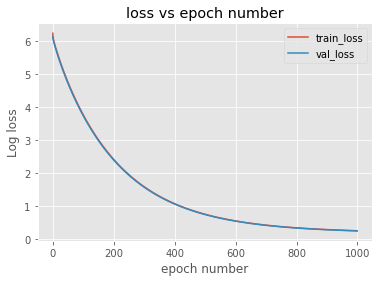

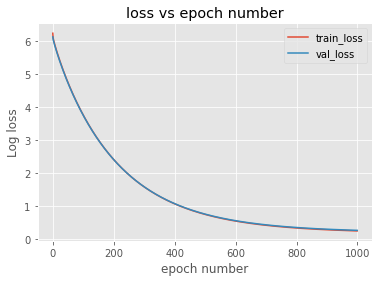

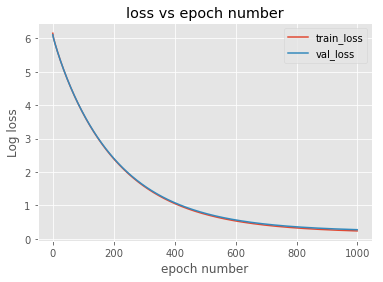

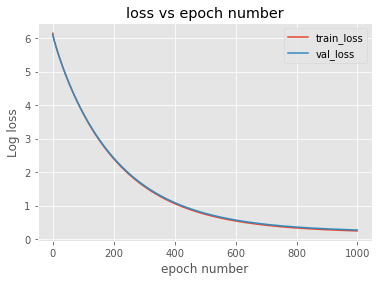

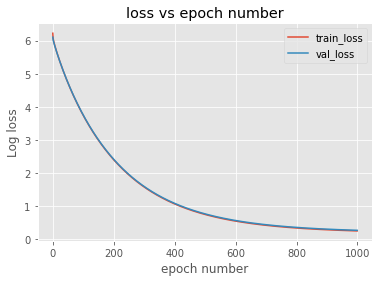

In [78]:
# Plot learning curves for validation and training data during learning
for history in train_results['history']:
    show_loss(history)

# EVALUATION ON TEST DATASET

In [79]:
# Overall Accuracy, Precision, Recall and F1 score for test dataset for each model from cross validation

test_results = {'Accuracy': [], 'Precision': [], 'Recall': [], 'F1_score': []}
confusion_matrixes = []
for model in train_results['models']:
    predicted = model.predict(x_test)
    
    predicted = np.asarray([np.round(j[0]) for j in predicted])
    actual = np.asarray([j[0] for j in y_test])
    
    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = metrics.accuracy_score(actual, predicted)
    
    test_results['Accuracy'].append(accuracy)
    test_results['Precision'].append(precision)
    test_results['Recall'].append(recall)
    test_results['F1_score'].append(f1)
    confusion_matrixes.append(confusion_matrix)
    
columns = ['Accuracy', 'Precision', 'Recall', 'F1_score']
indexes = ['K-fold {}'.format(i) for i in range(1, N_SPLITS+1)]
results_dataframe = pd.DataFrame(data=test_results, columns=columns, index=indexes)
results_dataframe

,Accuracy,Precision,Recall,F1_score
K-fold 1,0.991351,0.150943,0.870748,0.257286
K-fold 2,0.991971,0.163546,0.891156,0.276371
K-fold 3,0.989197,0.124758,0.877551,0.218459
K-fold 4,0.989829,0.131633,0.877551,0.228926
K-fold 5,0.991772,0.158477,0.877551,0.268470


In [80]:
# Confusion matrixes for each valdation
for matrix in confusion_matrixes:
    display(matrix)


,actual 1,actual 0
predicted 1,128,720
predicted 0,19,84576


,actual 1,actual 0
predicted 1,131,670
predicted 0,16,84626


,actual 1,actual 0
predicted 1,129,905
predicted 0,18,84391


,actual 1,actual 0
predicted 1,129,851
predicted 0,18,84445


,actual 1,actual 0
predicted 1,129,685
predicted 0,18,84611
